In [1]:
import os
import pandas as pd
import mne
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import re
from scipy import signal
from scipy.stats import zscore

beh_events_df = pd.read_csv('/scratch/jbruska/bids/EfrCourierOpenLoop/sub-M1017/ses-0/beh/sub-M1017_ses-0_task-EfrCourierOpenLoop_events.tsv', sep='\t')
ieeg_events_df = pd.read_csv('/scratch/jbruska/bids/EfrCourierOpenLoop/sub-M1017/ses-0/ieeg/sub-M1017_ses-0_task-EfrCourierOpenLoop_events.tsv', sep='\t')
channel_info = pd.read_csv('/scratch/jbruska/bids/EfrCourierOpenLoop/sub-M1017/ses-0/ieeg/sub-M1017_ses-0_task-EfrCourierOpenLoop_acq-bipolar_channels.tsv', sep='\t')

beh_events_df['data_from']='behavior'
ieeg_events_df['data_from']='ieeg'
df_combined = pd.concat([beh_events_df, ieeg_events_df], ignore_index=True)
df_combined['data_from']
df_combined_sorted = df_combined.sort_values(by="onset", ascending=True)
df_combined_sorted = df_combined_sorted.reset_index(drop=True)




In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Initialize reader and load events
evs =df_combined_sorted

# Define expected event counts
expected_counts = {
    'session_start': 1,
    'trial_start': 5,
    'encoding_word_start': 60,
    'stimming': '89 or 91',
    'pointing_start ': 65,
    'pointing_stop': 65,
    'fr_start': 5,
    'fr_stop': 5,
    'encoding_word_start': 60,
  
}

# Verify event counts
event_verification = {}
for event_type, expected in expected_counts.items():
    actual = len(evs[evs['trial_type'] == event_type])
    event_verification[event_type] = {
        'actual': actual,
        'expected': expected,
        'status': 'PASS' if (isinstance(expected, int) and actual == expected) or 
                           (isinstance(expected, str) and actual in [89, 91]) else 'FAIL'
    }
    print(f"{event_type}: {actual} / {expected} - {event_verification[event_type]['status']}")




session_start: 1 / 1 - PASS
trial_start: 5 / 5 - PASS
encoding_word_start: 56 / 60 - FAIL
stimming: 84 / 89 or 91 - FAIL
pointing_start : 0 / 65 - FAIL
pointing_stop: 69 / 65 - FAIL
fr_start: 5 / 5 - PASS
fr_stop: 5 / 5 - PASS


In [3]:
import pandas as pd

data = {"Event": ["session_start", "trial_start", "encoding_word_start", "stimming", "pointing_start", "pointing_stop", "fr_start", "fr_stop"],
        "Number run": [1,4,56,84,0,69,5,5], 
        "Total number of trials": [1,5,60,91,65,65,5,5],
        "Result": ["PASS", "PASS", "FAIL", "FAIL", "FAIL", "FAIL", "PASS", "PASS"]
       }
df=pd.DataFrame(data)
df.head()

Event  Number run  Total number of trials Result
0        session_start           1                       1   PASS
1          trial_start           4                       5   PASS
2  encoding_word_start          56                      60   FAIL
3             stimming          84                      91   FAIL
4       pointing_start           0                      65   FAIL

In [4]:
print("\n1.2 STIMULATION DELIVERY VALIDATION") 
print("-"*30)
Indexs=evs[evs['trial_type']=='stimming'].index
for Index in Indexs:
    if (evs.iloc[Index + 1]['onset'] - evs.iloc[Index]['onset']) <= 3:
        evs.at[Index + 1, 'burst_slow_frequency'] = evs.iloc[Index]['burst_slow_frequency']
list_evs=evs[evs['trial_type']=='encoding_word_start']
list_evs['burst_slow_frequency'].unique()
evs['trial_num'] = evs['trial_num'].fillna(-999)
trials = evs['trial_num'].unique() 
trials_new = [trial for trial in trials if trial != -999]

# Get indices where trials start (non-practice trials only)
#EVS_START = evs[(evs['trial_type'] == 'trial_start') & (evs['practice'] == 0)].index
EVS_START = evs[(evs['trial_type'] == 'trial_start') ].index
EVS_START = np.array(EVS_START)

# Assign trial numbers to each segment
for index_d in range(len(EVS_START)):
    start_idx = EVS_START[index_d]
    
    # For the last trial, go to the end of the dataframe
    if index_d == len(EVS_START)-1:
        end_idx = len(evs) - 1
    else:
        end_idx = EVS_START[index_d + 1] - 1  # End before the next trial starts
    
    # Use the trial number from the sorted trials list
    if index_d < len(EVS_START)+1:
        evs.loc[start_idx:end_idx, 'trial_num'] = trials_new[index_d]
        
def add_phase(evs):
    new_evs = pd.DataFrame([])
    for ind, list_evs in evs.groupby('trial_num'): # 'trial' is the aquivalent of a delivery day
        if list_evs['trial_num'].unique() != -999:
            list_evs['phase'] = 'nan' 
        if not list_evs[list_evs['trial_type'] == 'trial_start'].index.empty and not list_evs[list_evs['trial_type'] == 'deliveries_stop'].index.empty:
            # find indexes of encoding start and end
            first_pointing_index = min(list_evs[list_evs['trial_type']=='trial_start'].index)
            navigation_end_index = min(list_evs[list_evs['trial_type']=='deliveries_stop'].index) - 1
            list_evs.loc[first_pointing_index:navigation_end_index]['phase'] = 'encoding'
            first_pointing_index = min(list_evs[list_evs['trial_type']=='trial_start'].index)
            
            # find indexes of retrieval start and end
            rec_start_index = list_evs[list_evs['trial_type']=='fr_start'].index[0]
            rec_end_index = list_evs[list_evs['trial_type']=='fr_stop'].index[0]
            list_evs.loc[rec_start_index:rec_end_index]['phase'] = 'retrieval'
        new_evs = pd.concat([new_evs, list_evs])
    return new_evs

evs_new = add_phase(evs)
parameters_df2=pd.DataFrame()
for i,delivery_day_df in evs_new.groupby('trial_num'):
        if len(delivery_day_df['trial_type'].unique())>=0:
            encoding_df=delivery_day_df[delivery_day_df['phase']=='encoding']
            encoding_stim_num = len(encoding_df[encoding_df['trial_type']=='stimming'])
          
            retrieval_df=delivery_day_df[delivery_day_df['phase']=='retrieval']
            retrieval_stim_num = len(retrieval_df[retrieval_df['trial_type']=='stimming'])
           # recall_rate = len(delivery_day_df[delivery_day_df['recalled']==1]) / (len(delivery_day_df[delivery_day_df['recalled']==0]) + len(delivery_day_df[delivery_day_df['recalled']==1]))
           # intrusion = len(delivery_day_df[(delivery_day_df['intrusion']==-1) | (delivery_day_df['intrusion']>0)]) 
            stim_df=delivery_day_df[delivery_day_df['trial_type']=='stimming']
            burst_freq=stim_df['burst_slow_frequency'].unique()
            retrieval_item_list = set(retrieval_df['item'].dropna().str.lower().unique())
            encode_stim_set = set(encoding_df['item'].dropna().str.lower().unique())
            Number_send=len(encode_stim_set)
            idx_lead1_pos = channel_info[channel_info['lead1'].isin(delivery_day_df['electrode_pos'])].index
            idx_lead1_neg = channel_info[channel_info['lead1'].isin(delivery_day_df['electrode_neg'])].index
            idx_lead2_pos = channel_info[channel_info['lead2'].isin(delivery_day_df['electrode_pos'])].index  
            idx_lead2_neg = channel_info[channel_info['lead2'].isin(delivery_day_df['electrode_neg'])].index
            sets = [set(idx_lead1_pos), set(idx_lead1_neg), set(idx_lead2_pos), set(idx_lead2_neg)]
            from collections import Counter

            # Flatten all sets and count occurrences
            all_numbers = []
            for s in sets:
                all_numbers.extend(s)

            # Count how many times each number appears
            counts = Counter(all_numbers)

            # Get numbers that appear exactly twice
            numbers_twice = [num for num, count in counts.items() if count == 2]
            stim_channel=[]
            correct_recall=[]
            if len(all_numbers)>0:
                stim_channel=channel_info['name'].iloc[numbers_twice]
                correct_recall = len(retrieval_item_list.intersection(encode_stim_set))
                stim_channel=channel_info['name'].iloc[numbers_twice].values[0]
            parameters_df2 = parameters_df2.append({'Burst frequency (Hz)':burst_freq,'DD':delivery_day_df['trial_num'].unique()[0],
                                                   'Number of encoding stim':encoding_stim_num,'Number of retrieval stim (EFR)':retrieval_stim_num, 
                                                    'Number of item send':Number_send,'recalled item':correct_recall,'STIM_channel':stim_channel 
                                                   },ignore_index=True)
    #         parameters_df2 = parameters_df2.append({'Burst frequency (Hz)':burst_freq,'DD':delivery_day_df['trial'].unique()[0],
    #                                                'Number of encoding stim':encoding_stim_num,'Number of retrieval stim (EFR)':retrieval_stim_num,
    #                                                'Number of FSR stim':FSR_stim_num,'Number of FFR stim':FFR_stim_num},ignore_index=True)
parameters_df2




1.2 STIMULATION DELIVERY VALIDATION
------------------------------


/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Burst frequency (Hz)     DD  Number of encoding stim  \
0                   [] -999.0                      0.0   
1                   []   -1.0                      0.0   
2                [8.0]    0.0                      6.0   
3                [3.0]    1.0                      6.0   
4                [8.0]    2.0                      6.0   
5                [3.0]    3.0                      6.0   

   Number of retrieval stim (EFR)  Number of item send recalled item  \
0                             0.0                  0.0            []   
1                             0.0                  8.0            []   
2                            15.0                 12.0             3   
3                            15.0                 12.0             3   
4                            15.0                 12.0             2   
5                            15.0                 12.0             2   

  STIM_channel  
0           []  
1           []  
2      RB1_RB2  
3      RB1_RB2  
4      RB1_RB2  
5      RB1_RB2

In [5]:
parameters_df2[2:]

Burst frequency (Hz)   DD  Number of encoding stim  \
2                [8.0]  0.0                      6.0   
3                [3.0]  1.0                      6.0   
4                [8.0]  2.0                      6.0   
5                [3.0]  3.0                      6.0   

   Number of retrieval stim (EFR)  Number of item send recalled item  \
2                            15.0                 12.0             3   
3                            15.0                 12.0             3   
4                            15.0                 12.0             2   
5                            15.0                 12.0             2   

  STIM_channel  
2      RB1_RB2  
3      RB1_RB2  
4      RB1_RB2  
5      RB1_RB2

In [6]:
result_8HZ_encoding= evs_new[(evs_new['phase'] == 'encoding') & (evs_new['burst_slow_frequency'] == 8) & (evs_new['trial_type'] == 'stimming')]
result_3HZ_encoding= evs_new[(evs_new['phase'] == 'encoding') & (evs_new['burst_slow_frequency'] == 3)& (evs_new['trial_type'] == 'stimming')]
result_8HZ_retrieval= evs_new[(evs_new['phase'] == 'retrieval') & (evs_new['burst_slow_frequency'] == 8)& (evs_new['trial_type'] == 'stimming')]
result_3HZ_retrieval= evs_new[(evs_new['phase'] == 'retrieval') & (evs_new['burst_slow_frequency'] == 3)& (evs_new['trial_type'] == 'stimming')]
result_none_encoding = evs[(evs['trial_type'] == 'encoding_word_start') & (evs['stim_condition'] == False)]
print(f"\nStimulation distribution by phase :")
print(f"Encoding - 3 Hz: {len(result_3HZ_encoding)}, 8 Hz: {len(result_8HZ_encoding)}, None: {len(result_none_encoding)}")
print(f"Retrieval - 3 Hz: {len(result_3HZ_retrieval)}, 8 Hz: {len(result_8HZ_retrieval)}")


Stimulation distribution by phase :
Encoding - 3 Hz: 12, 8 Hz: 12, None: 29
Retrieval - 3 Hz: 30, 8 Hz: 30


In [7]:
 # sampling rate in Hz
raw = mne.io.read_raw_edf('/scratch/jbruska/bids/EfrCourierOpenLoop/sub-M1017/ses-0/ieeg/sub-M1017_ses-0_task-EfrCourierOpenLoop_acq-bipolar_ieeg.edf', preload=False)
sr =  raw.info['sfreq']
def segment(result_df,sfreq,tmin,tmax):
    events_samples = result_df['onset']*sfreq   # convert ms → s → samples
    events = np.zeros((len(events_samples), 3), dtype=int)
    events[:, 0] = events_samples                  # sample numbers
    events[:, 1] = 0                               # previous value, 0 if no trigger channel
    #events[:, 2] = [event_id_dict[str(etype)] for etype in events_type]  # event IDs
    events[:, 2] = 1
   
    epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)
    data = epochs.get_data()
    return data
eeg_8HZ = segment(result_8HZ_encoding,sr,-1,10)
eeg_3HZ = segment(result_3HZ_encoding,sr,-1,10)
eeg_8HZ_retrieval = segment(result_8HZ_retrieval,sr,-1,10)
eeg_3HZ_retrieval = segment(result_3HZ_retrieval,sr,-1,10)
eeg_no_encoding = segment(result_none_encoding,sr,-1,10)
total_samples = eeg_8HZ.shape[2]
time_window=10000
time_axis = np.linspace(-1000, time_window, total_samples)

print(f"Sample rate: {sr} Hz")
print(f"EEG data shapes:")
print(f"  8 Hz encoding: {eeg_8HZ.shape}")
print(f"  3 Hz encoding: {eeg_3HZ.shape}")
print(f"  No stimuli encoding: {eeg_no_encoding.shape}")
print(f"Time axis range: {time_axis[0]:.1f} to {time_axis[-1]:.1f} ms")



Extracting EDF parameters from /scratch/jbruska/bids/EfrCourierOpenLoop/sub-M1017/ses-0/ieeg/sub-M1017_ses-0_task-EfrCourierOpenLoop_acq-bipolar_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 11001 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 11001 original time points ...
0 bad epochs dropped
Not setting metadata
30 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 11001 original time points ...
0 bad epochs dropped
Not setting metadata
30 m

In [8]:
def identify_stimulated_channels(delivery_day_df, channel_info):
    # Find channels where leads match electrodes
    idx_lead1_pos = channel_info[channel_info['lead1'].isin(delivery_day_df['electrode_pos'])].index
    idx_lead1_neg = channel_info[channel_info['lead1'].isin(delivery_day_df['electrode_neg'])].index
    idx_lead2_pos = channel_info[channel_info['lead2'].isin(delivery_day_df['electrode_pos'])].index  
    idx_lead2_neg = channel_info[channel_info['lead2'].isin(delivery_day_df['electrode_neg'])].index
    
    # Combine and count occurrences
    sets = [set(idx_lead1_pos), set(idx_lead1_neg), set(idx_lead2_pos), set(idx_lead2_neg)]
    all_numbers = [num for s in sets for num in s]  # Flatten
    
    from collections import Counter
    counts = Counter(all_numbers)
    
    numbers_twice = [num for num, count in counts.items() if count == 2]
    numbers_once = [num for num, count in counts.items() if count == 1]
    
    # Handle case where no stimulation pairs found
    if not numbers_twice:
        return [], [], []
    
    # Get stimulation info
    stim_group = channel_info['group'].iloc[numbers_twice[0]]
    
    # Find channels in same group but not stimulated
    same_shank = (channel_info['group'] == stim_group).copy()
    all_contact_indices = np.concatenate([idx_lead1_pos, idx_lead1_neg, idx_lead2_pos, idx_lead2_neg])
    same_shank.iloc[np.unique(all_contact_indices)] = False
    
    # Get results
    index_other = channel_info[channel_info['group'] != stim_group].index
    channel_stimuli_indices = same_shank[same_shank].index
    contact_stimuli_indices = numbers_twice
    
    return index_other, channel_stimuli_indices, contact_stimuli_indices
Index_other_8, Channel_stimuli_8, Contact_stimuli_8 = identify_stimulated_channels(result_8HZ_encoding, channel_info)
Index_other_3, Channel_stimuli_3, Contact_stimuli_3 = identify_stimulated_channels(result_3HZ_encoding, channel_info)

In [9]:
np.shape(eeg_8HZ)

(12, 124, 11001)


2.1 EEG Response for simulation Visualization
------------------------------


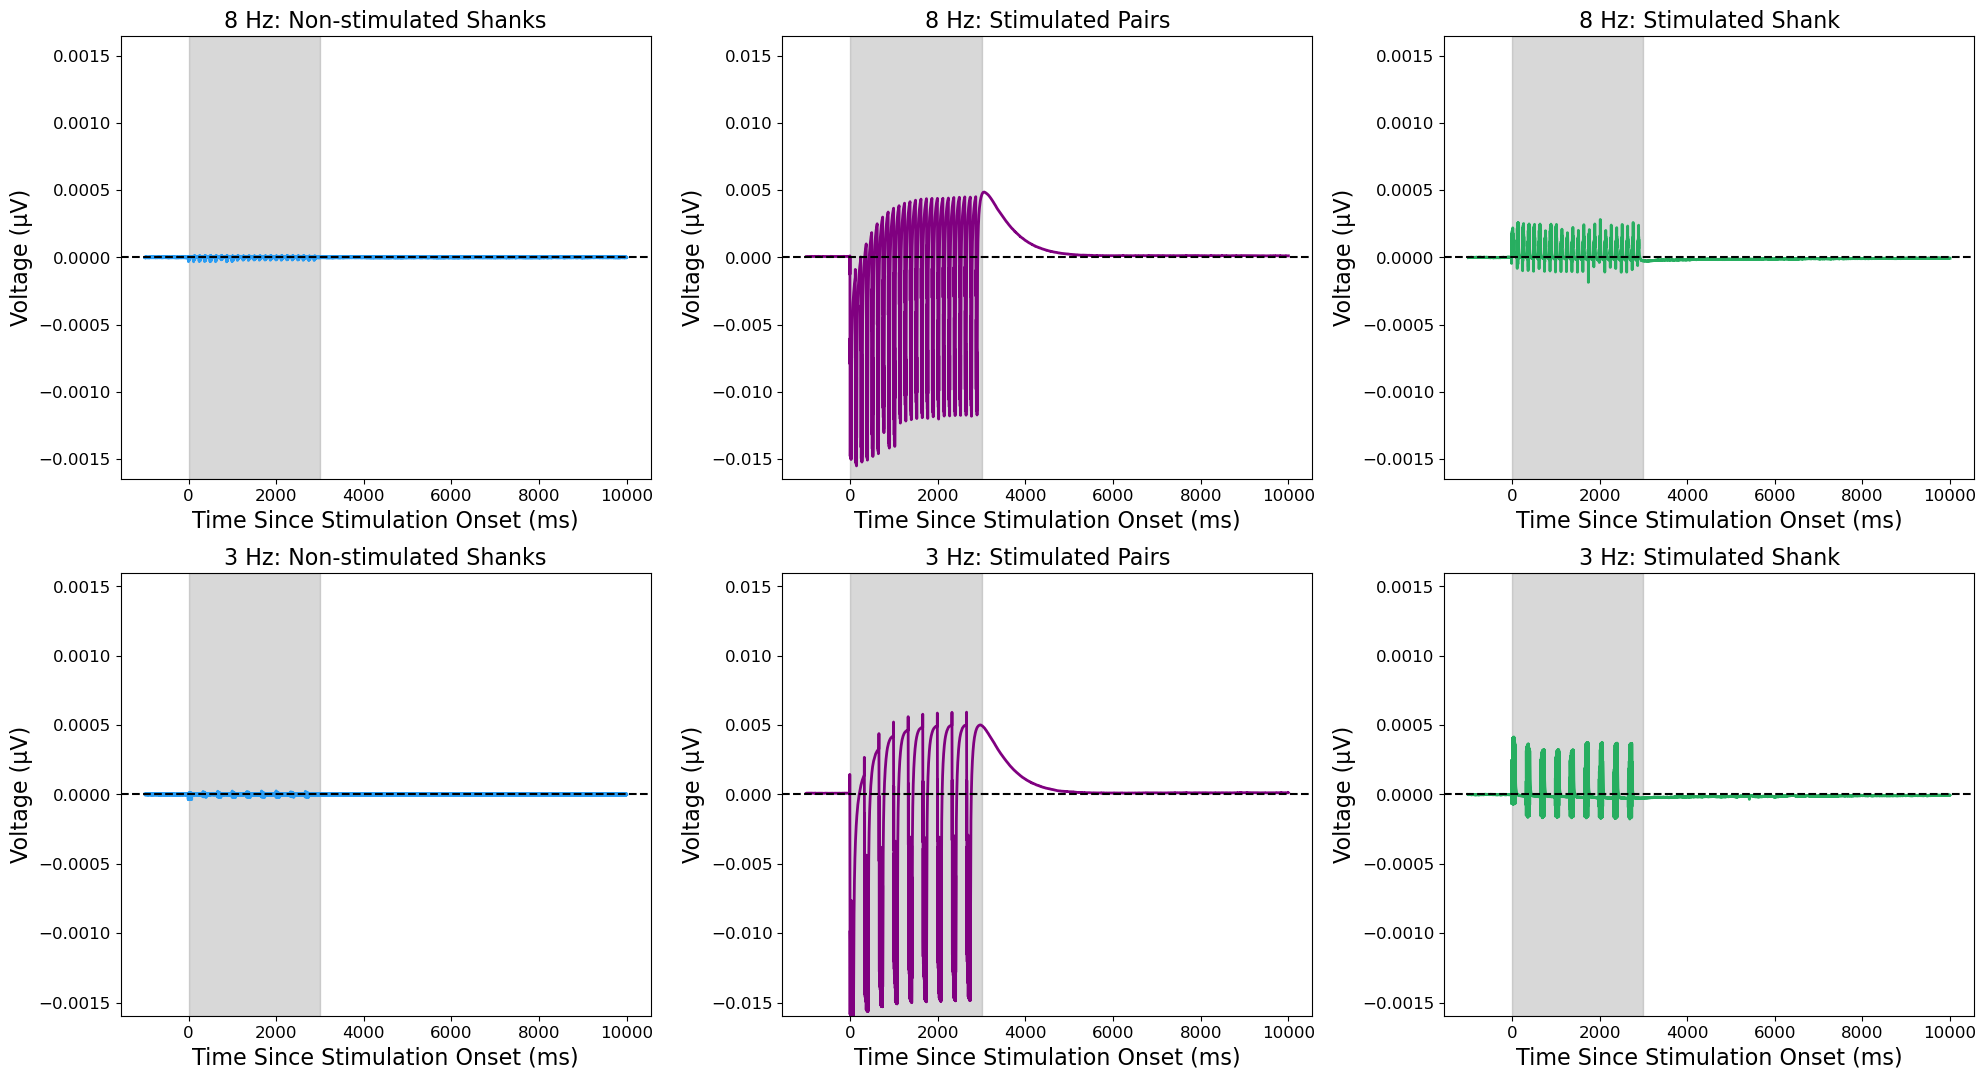

<Figure size 640x480 with 0 Axes>

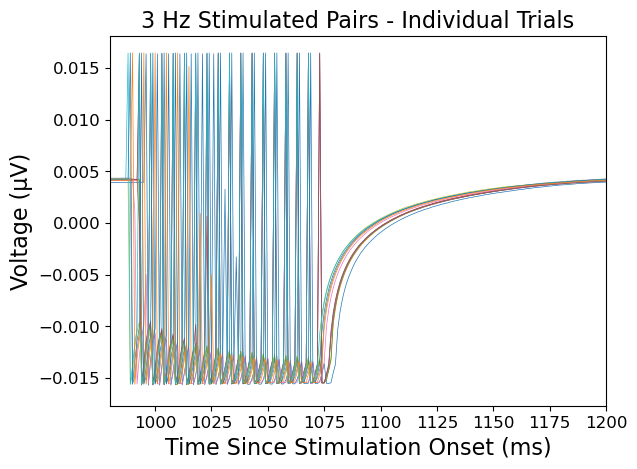

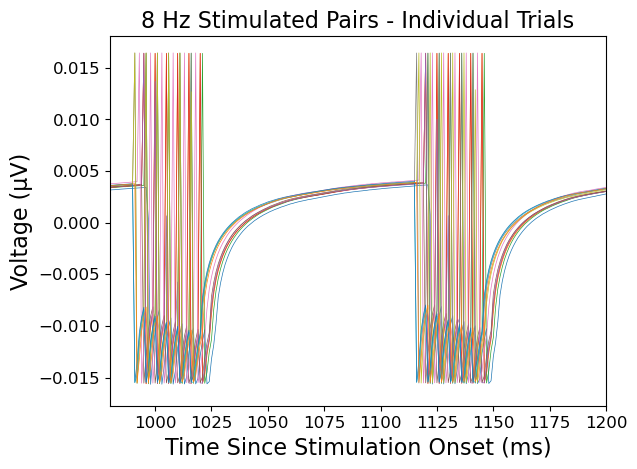

In [10]:
write_fig_path = "."
print("\n2.1 EEG Response for simulation Visualization")
print("-"*30)
bed_channel=[]
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
channel = [i for i in range(np.shape(eeg_8HZ)[1]) if i not in bed_channel]

# Define stimulus period in time coordinates
stim_start_time, stim_end_time = 0,3000# ms






# Plot 2: Channel-specific analysis for 8 Hz
if Contact_stimuli_8:
    avg_eeg_other_8 = np.mean(eeg_8HZ[:, Index_other_8, :], axis=1)
    avg_eeg_stimuli_8 = np.mean(eeg_8HZ[:, Contact_stimuli_8, :], axis=1)
    avg_eeg_channel_8 = np.mean(eeg_8HZ[:, Channel_stimuli_8, :], axis=1)

    ax4 = plt.subplot(3, 3, 4)
    plt.plot(time_axis, np.mean(avg_eeg_other_8, axis=0), linewidth=2, color='#2a9df4', label='Other Channels')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
    plt.ylabel('Voltage (µV)', fontsize = 16)
    plt.title('8 Hz: Non-stimulated Shanks', fontsize = 16)
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    ax4_max = np.max(np.abs(avg_eeg_stimuli_8))/10
    ax4.set_ylim(-ax4_max, ax4_max)

    ax5 = plt.subplot(3, 3, 5)
    plt.plot(time_axis, np.mean(avg_eeg_stimuli_8, axis=0), linewidth=2, color='purple', label='Stimulated Pairs')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
    plt.ylabel('Voltage (µV)', fontsize = 16)
    plt.title('8 Hz: Stimulated Pairs', fontsize = 16)
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    ax5_max = np.max(np.abs(avg_eeg_stimuli_8))
    ax5.set_ylim(-ax5_max, ax5_max)


    ax6 = plt.subplot(3, 3, 6)
    plt.plot(time_axis, np.mean(avg_eeg_channel_8, axis=0), linewidth=2, color='#27AE60', label='Stimulated Shank')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
    plt.ylabel('Voltage (µV)', fontsize = 16)
    plt.title('8 Hz: Stimulated Shank', fontsize = 16)
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    ax6_max = np.max(np.abs(avg_eeg_stimuli_8))/10
    ax6.set_ylim(-ax6_max, ax6_max)
   

# Plot 3: Channel-specific analysis for 3 Hz
if Contact_stimuli_3:
    avg_eeg_other_3 = np.mean(eeg_3HZ[:, Index_other_3, :], axis=1)
    avg_eeg_stimuli_3 = np.mean(eeg_3HZ[:, Contact_stimuli_3, :], axis=1)
    avg_eeg_channel_3 = np.mean(eeg_3HZ[:, Channel_stimuli_3, :], axis=1)

    ax7 = plt.subplot(3, 3, 7)
    plt.plot(time_axis, np.mean(avg_eeg_other_3, axis=0), linewidth=2, color='#2a9df4', label='Other Channels')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
    plt.ylabel('Voltage (µV)', fontsize = 16)
    plt.title('3 Hz: Non-stimulated Shanks', fontsize = 16)
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

    

    ax8 = plt.subplot(3, 3, 8)
    mean_stimuli_3 = np.mean(avg_eeg_stimuli_3, axis=0)
    plt.plot(time_axis, mean_stimuli_3, linewidth=2, color='purple', label='Stimulated Pairs')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
    plt.ylabel('Voltage (µV)', fontsize = 16)
    plt.title('3 Hz: Stimulated Pairs', fontsize = 16)
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
  
 # Set ax8 y-limits to its maximum value
    ax8_max = np.max(np.abs(mean_stimuli_3))
    ax8.set_ylim(-ax8_max, ax8_max)

    # Calculate reduced range for ax7 and ax9
    reduced_range = ax8_max / 10

    ax9 = plt.subplot(3, 3, 9)
    plt.plot(time_axis, np.mean(avg_eeg_channel_3, axis=0), linewidth=2, color='#27AE60', label='Stimulated Shank')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
    plt.ylabel('Voltage (µV)', fontsize = 16)
    plt.title('3 Hz: Stimulated Shank', fontsize = 16)
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)


    # Set ax7 and ax9 y-limits to ax8_max / 10
    ax7.set_ylim(-reduced_range, reduced_range)
    ax9.set_ylim(-reduced_range, reduced_range)
    plt.tight_layout()

    plt.savefig(f"{write_fig_path}/2x3_plot.pdf",
            transparent=True,
            bbox_inches='tight',
            pad_inches=0.08,
            format='pdf')

    plt.show()

   

    plt.tight_layout()

fig, ax10 = plt.subplots()
ax10.plot(time_axis, avg_eeg_stimuli_3.T, linewidth=0.5)
ax10.axvline(x=0, color='k', linestyle='--')

ax10.set_xlim(980, 1200)
ax10.set_xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
ax10.set_ylabel('Voltage (µV)', fontsize = 16)
ax10.set_title('3 Hz Stimulated Pairs - Individual Trials', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f"{write_fig_path}/3Hzfigure.pdf",
            transparent=True,
            bbox_inches='tight',
            pad_inches=0.08,
            format='pdf')
plt.show()




fig, ax10 = plt.subplots()
ax10.plot(time_axis, avg_eeg_stimuli_8.T, linewidth=0.5)
ax10.axvline(x=0, color='k', linestyle='--')

ax10.set_xlim(980, 1200)
ax10.set_xlabel('Time Since Stimulation Onset (ms)', fontsize = 16)
ax10.set_ylabel('Voltage (µV)', fontsize = 16)
ax10.set_title('8 Hz Stimulated Pairs - Individual Trials', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f"{write_fig_path}/8Hzfigure.pdf",
            transparent=True,
            bbox_inches='tight',
            pad_inches=0.08,
            format='pdf')

plt.show()




 


2.1 EEG Response for simulation Visualization during retrival
------------------------------


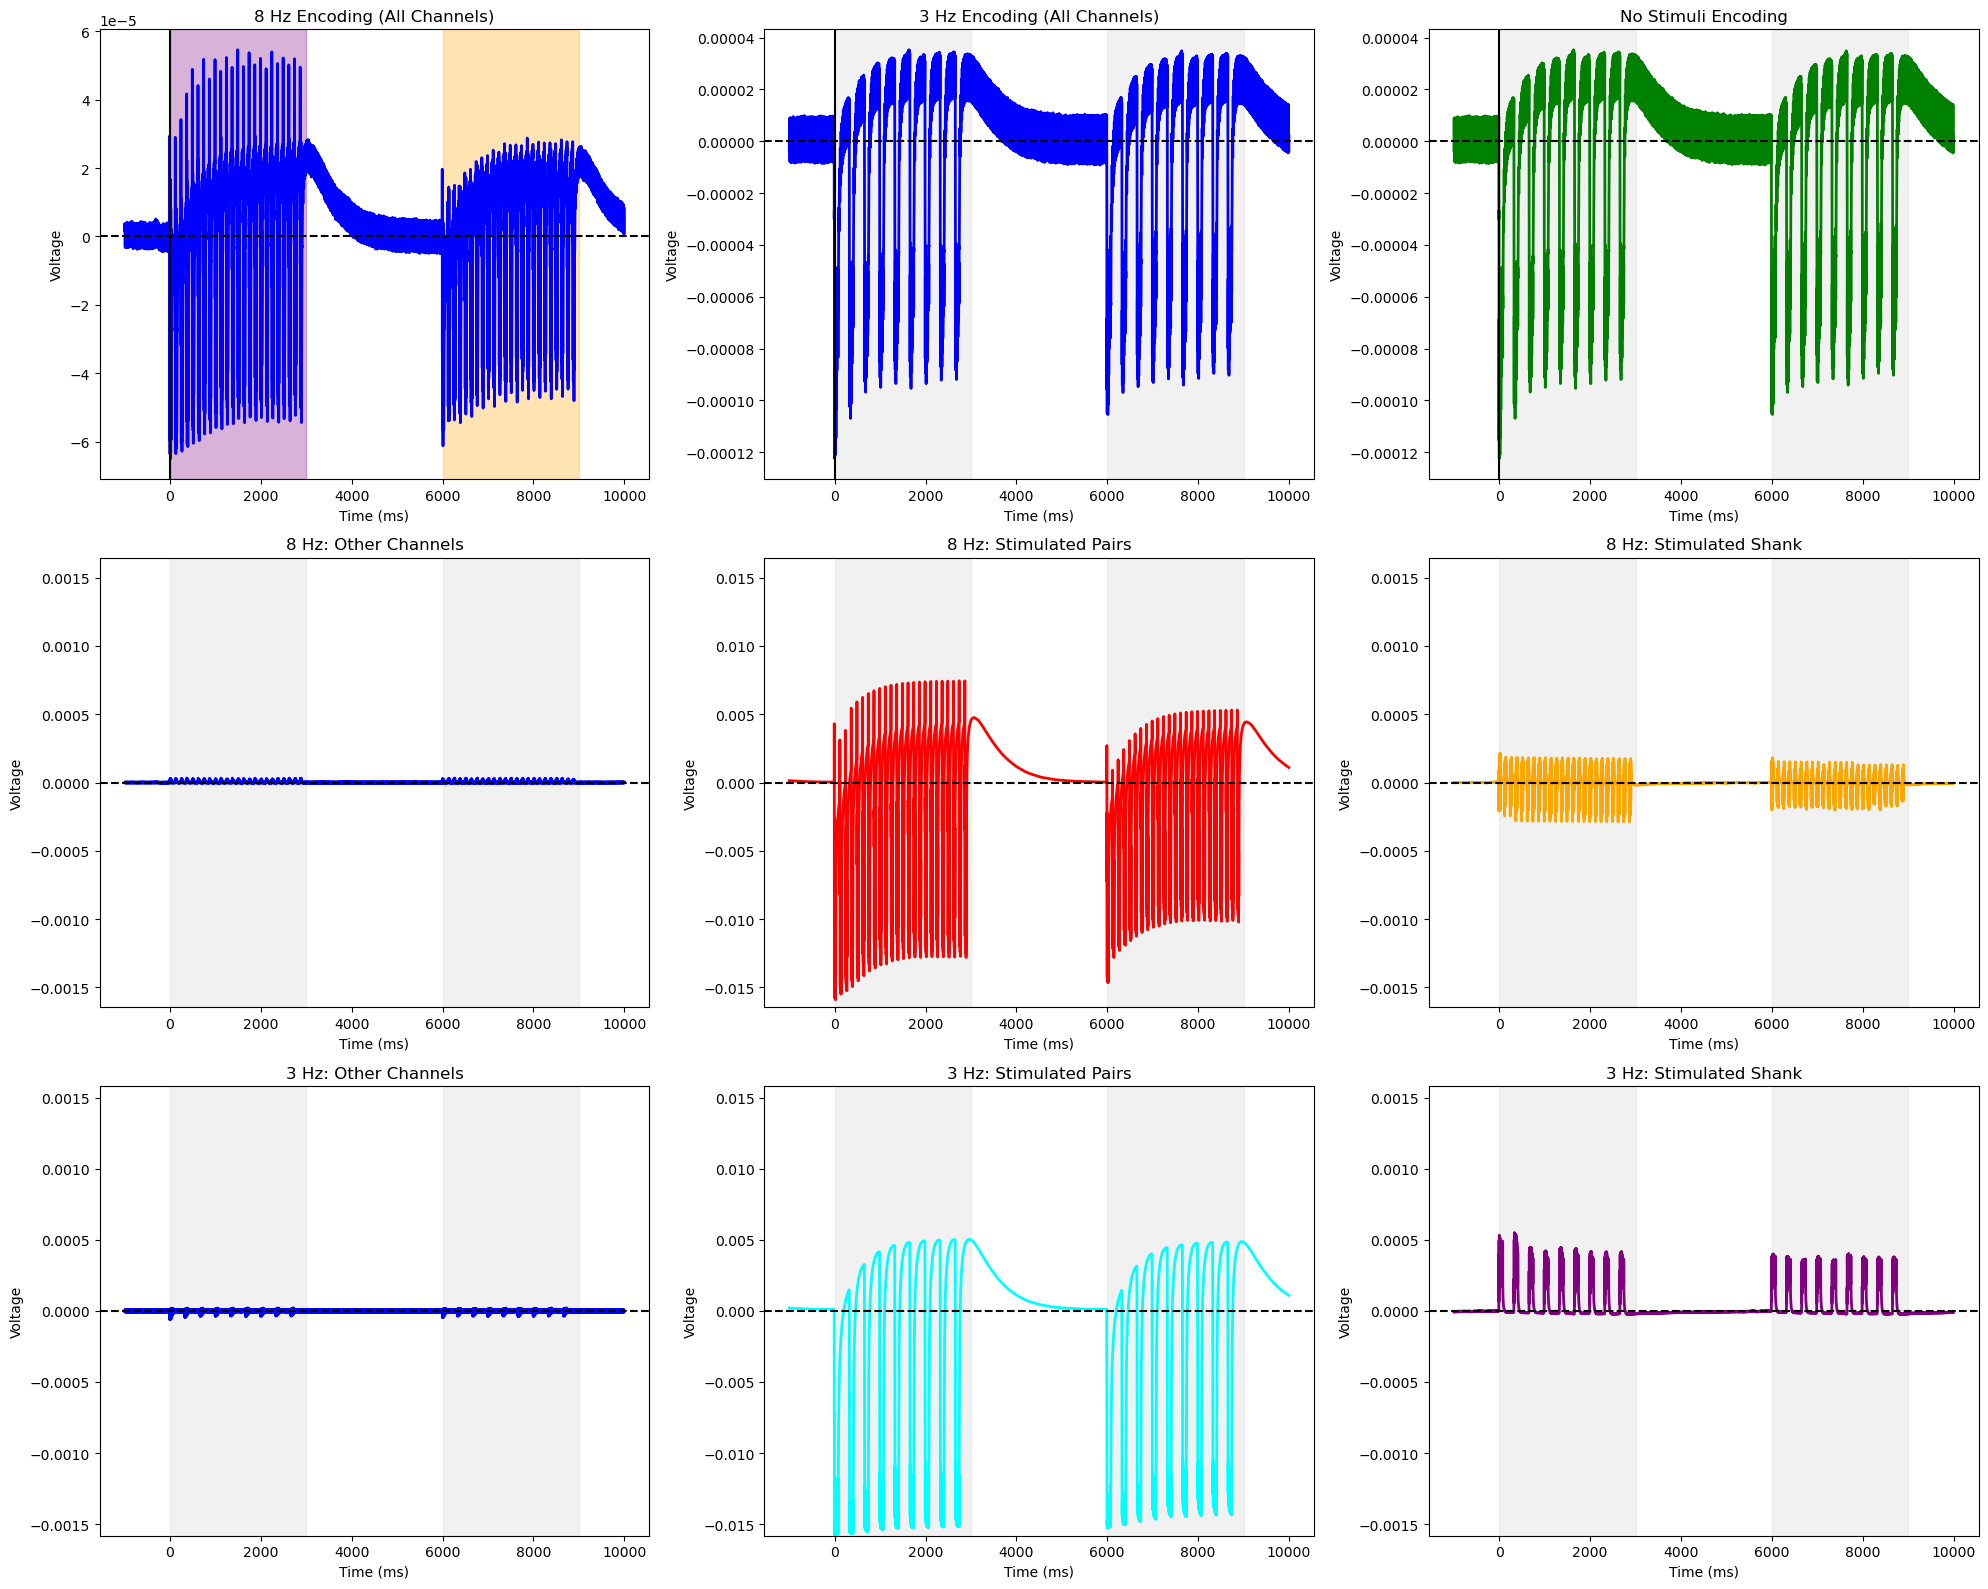

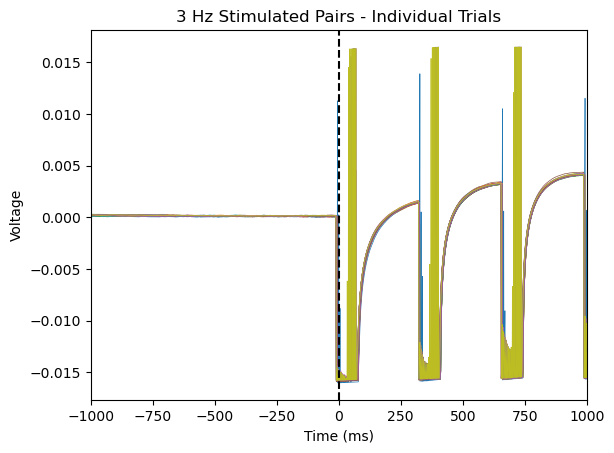

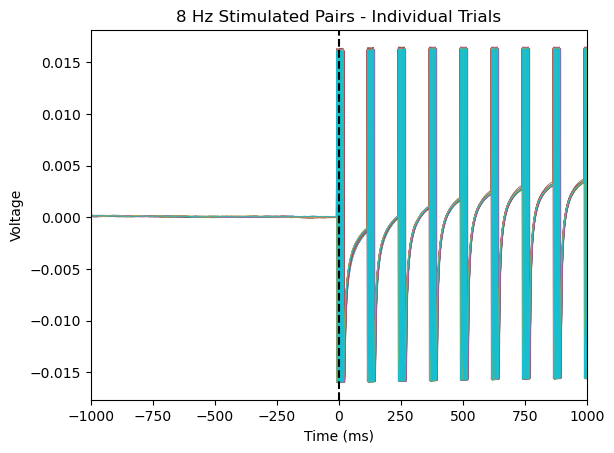

In [11]:
print("\n2.1 EEG Response for simulation Visualization during retrival")
print("-"*30)
bed_channel=[]
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
channel = [i for i in range(np.shape(eeg_8HZ)[1]) if i not in bed_channel]
Index_other_8, Channel_stimuli_8, Contact_stimuli_8 = identify_stimulated_channels(result_8HZ_retrieval, channel_info)
Index_other_3, Channel_stimuli_3, Contact_stimuli_3 = identify_stimulated_channels(result_3HZ_retrieval, channel_info)
# Define stimulus period in time coordinates
stim_start_time, stim_end_time = 0, 3000
stim_start_time_2, stim_end_time_2 = 6000, 9000# ms
total_samples = eeg_8HZ_retrieval.shape[2]
time_window=10000
time_axis = np.linspace(-1000, time_window, total_samples)
# Plot 1: Overall EEG responses (2x2 grid)
ax1 = plt.subplot(3, 3, 1)
avg_eeg = np.mean(eeg_8HZ_retrieval[:, channel, :], 0)
plt.plot(time_axis, np.mean(avg_eeg[:, :], 0), linewidth=2, color='blue')
plt.axvline(x=0, color='k', linestyle='-')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')
plt.title('8 Hz Encoding (All Channels)')
plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='purple')
plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='orange')
ax2 = plt.subplot(3, 3, 2)
avg_eeg = np.mean(eeg_3HZ_retrieval[:, channel, :], 0)
plt.plot(time_axis, np.mean(avg_eeg[:, :], 0), linewidth=2, color='blue')
plt.axvline(x=0, color='k', linestyle='-')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')
plt.title('3 Hz Encoding (All Channels)')
plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')
ax3 = plt.subplot(3, 3, 3)
avg_eeg = np.mean(eeg_3HZ_retrieval[:, channel, :], 0)
plt.plot(time_axis, np.mean(avg_eeg[:, :], 0), linewidth=2, color='green')
plt.axvline(x=0, color='k', linestyle='-')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')
plt.title('No Stimuli Encoding')
plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')
# Plot 2: Channel-specific analysis for 8 Hz
if Contact_stimuli_8:
    avg_eeg_other_8 = np.mean(eeg_8HZ_retrieval[:, Index_other_8, :], axis=1)
    avg_eeg_stimuli_8 = np.mean(eeg_8HZ_retrieval[:, Contact_stimuli_8, :], axis=1)
    avg_eeg_channel_8 = np.mean(eeg_8HZ_retrieval[:, Channel_stimuli_8, :], axis=1)

    ax4 = plt.subplot(3, 3, 4)
    plt.plot(time_axis, np.mean(avg_eeg_other_8, axis=0), linewidth=2, color='blue', label='Other Channels')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('8 Hz: Other Channels')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')
    ax4_max = np.max(np.abs(avg_eeg_stimuli_8))/10
    ax4.set_ylim(-ax4_max, ax4_max)

    ax5 = plt.subplot(3, 3, 5)
    plt.plot(time_axis, np.mean(avg_eeg_stimuli_8, axis=0), linewidth=2, color='red', label='Stimulated Pairs')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('8 Hz: Stimulated Pairs')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')
    ax5_max = np.max(np.abs(avg_eeg_stimuli_8))
    ax5.set_ylim(-ax5_max, ax5_max)

    ax6 = plt.subplot(3, 3, 6)
    plt.plot(time_axis, np.mean(avg_eeg_channel_8, axis=0), linewidth=2, color='orange', label='Stimulated Shank')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('8 Hz: Stimulated Shank')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')
    ax6_max = np.max(np.abs(avg_eeg_stimuli_8))/10
    ax6.set_ylim(-ax6_max, ax6_max)

# Plot 3: Channel-specific analysis for 3 Hz
if Contact_stimuli_3:
    avg_eeg_other_3 = np.mean(eeg_3HZ_retrieval[:, Index_other_3, :], axis=1)
    avg_eeg_stimuli_3 = np.mean(eeg_3HZ_retrieval[:, Contact_stimuli_3, :], axis=1)
    avg_eeg_channel_3 = np.mean(eeg_3HZ_retrieval[:, Channel_stimuli_3, :], axis=1)

    ax7 = plt.subplot(3, 3, 7)
    plt.plot(time_axis, np.mean(avg_eeg_other_3, axis=0), linewidth=2, color='blue', label='Other Channels')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('3 Hz: Other Channels')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')

    ax8 = plt.subplot(3, 3, 8)
    mean_stimuli_3 = np.mean(avg_eeg_stimuli_3, axis=0)
    plt.plot(time_axis, mean_stimuli_3, linewidth=2, color='cyan', label='Stimulated Pairs')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('3 Hz: Stimulated Pairs')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')

    # Set ax8 y-limits to its maximum value
    ax8_max = np.max(np.abs(mean_stimuli_3))
    ax8.set_ylim(-ax8_max, ax8_max)

    # Calculate reduced range for ax7 and ax9
    reduced_range = ax8_max / 10

    ax9 = plt.subplot(3, 3, 9)
    plt.plot(time_axis, np.mean(avg_eeg_channel_3, axis=0), linewidth=2, color='purple', label='Stimulated Shank')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    plt.title('3 Hz: Stimulated Shank')
    plt.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    plt.axvspan(stim_start_time_2, stim_end_time_2, alpha=0.3, color='lightgrey')

    # Set ax7 and ax9 y-limits to ax8_max / 10
    ax7.set_ylim(-reduced_range, reduced_range)
    ax9.set_ylim(-reduced_range, reduced_range)

plt.tight_layout()
plt.show()

fig, ax10 = plt.subplots()
ax10.plot(time_axis, avg_eeg_stimuli_3.T, linewidth=0.5)
ax10.axvline(x=0, color='k', linestyle='--')
ax10.set_xlim(-1000, 1000)
ax10.set_xlabel('Time (ms)')
ax10.set_ylabel('Voltage')
ax10.set_title('3 Hz Stimulated Pairs - Individual Trials')
plt.show()

fig, ax10 = plt.subplots()
ax10.plot(time_axis, avg_eeg_stimuli_8.T, linewidth=0.5)
ax10.axvline(x=0, color='k', linestyle='--')
ax10.set_xlim(-1000, 1000)
ax10.set_xlabel('Time (ms)')
ax10.set_ylabel('Voltage')
ax10.set_title('8 Hz Stimulated Pairs - Individual Trials')
plt.show()


PHASE 3: CHANNEL QUALITY ASSESSMENT
--------------------------------------------------
------------------------------


No handles with labels found to put in legend.


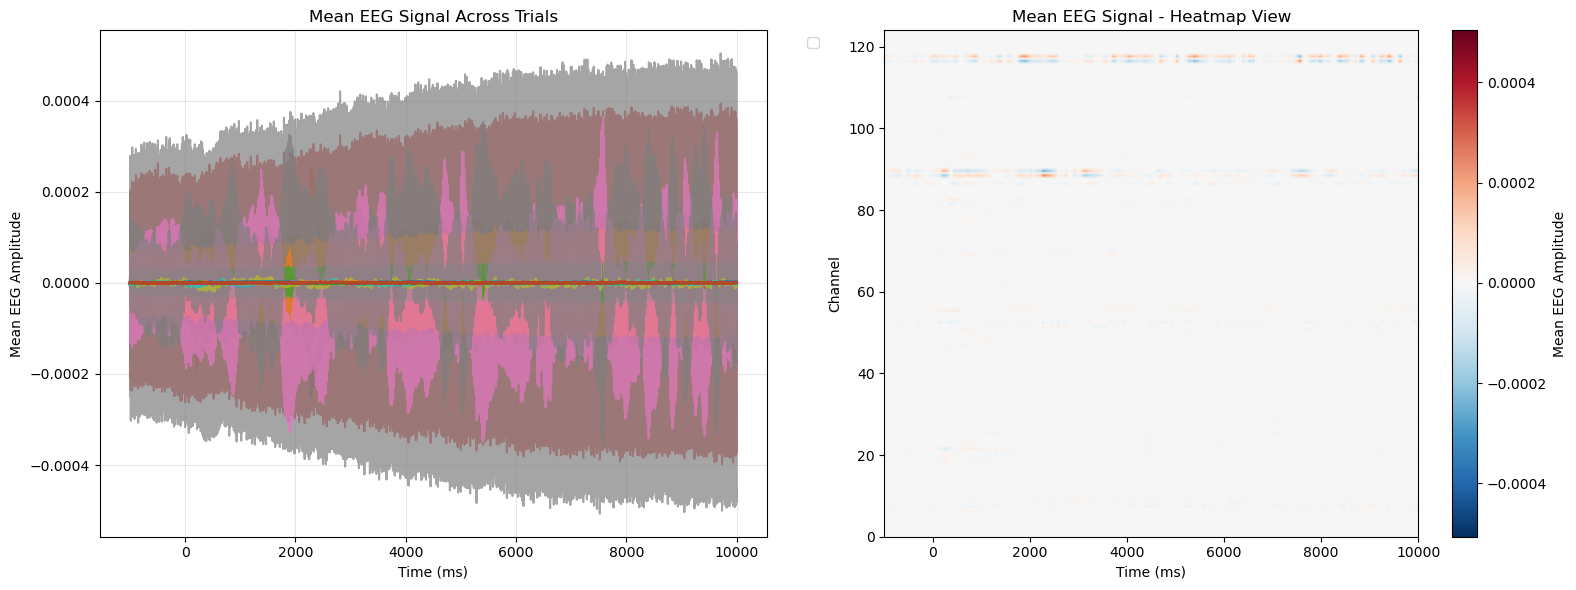

In [12]:
# =============================================================================
# PHASE 3: CHANNEL QUALITY ASSESSMENT
# =============================================================================
print("\n" + "="*80)
print("PHASE 3: CHANNEL QUALITY ASSESSMENT")
print("-"*50)
channel = [i for i in range(np.shape(eeg_8HZ)[1]) if i not in bed_channel]
channels =channel_info['name']
print("-"*30)
  # Raw DATA :
  # Create subplots with 1 row and 2 columns

eeg_mean = np.mean(eeg_no_encoding[:, channel, :], 0)
# First subplot - Line plot
# Plot each channel (rows 1-9 from the mean result)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for i in range(eeg_mean.shape[0]):
    ax1.plot(time_axis, eeg_mean[i, :], alpha=0.7)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Mean EEG Amplitude')
ax1.set_title('Mean EEG Signal Across Trials')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Second subplot - Heatmap
im = ax2.imshow(eeg_mean, aspect='auto', cmap='RdBu_r', origin='lower', 
                extent=[time_axis[0], time_axis[-1], 0, eeg_mean.shape[0]])
plt.colorbar(im, ax=ax2, label='Mean EEG Amplitude')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Channel')
ax2.set_title('Mean EEG Signal - Heatmap View')
# ax2.set_yticks(range(eeg_mean.shape[0]), [f'Ch {i+2}' for i in range(eeg_mean.shape[0])])

plt.tight_layout()
plt.show()

#

Total channels analyzed: 124
Channels with high variability (|z-score| > 2): 4

Potential problematic channels:
  Channel 93: LR8_LR9 (z-score: 5.65)
  Channel 107: LIM4_LIM5 (z-score: 7.38)
  Channel 116: LAP4_LAP5 (z-score: 2.72)
  Channel 117: LAP5_LAP6 (z-score: 2.72)


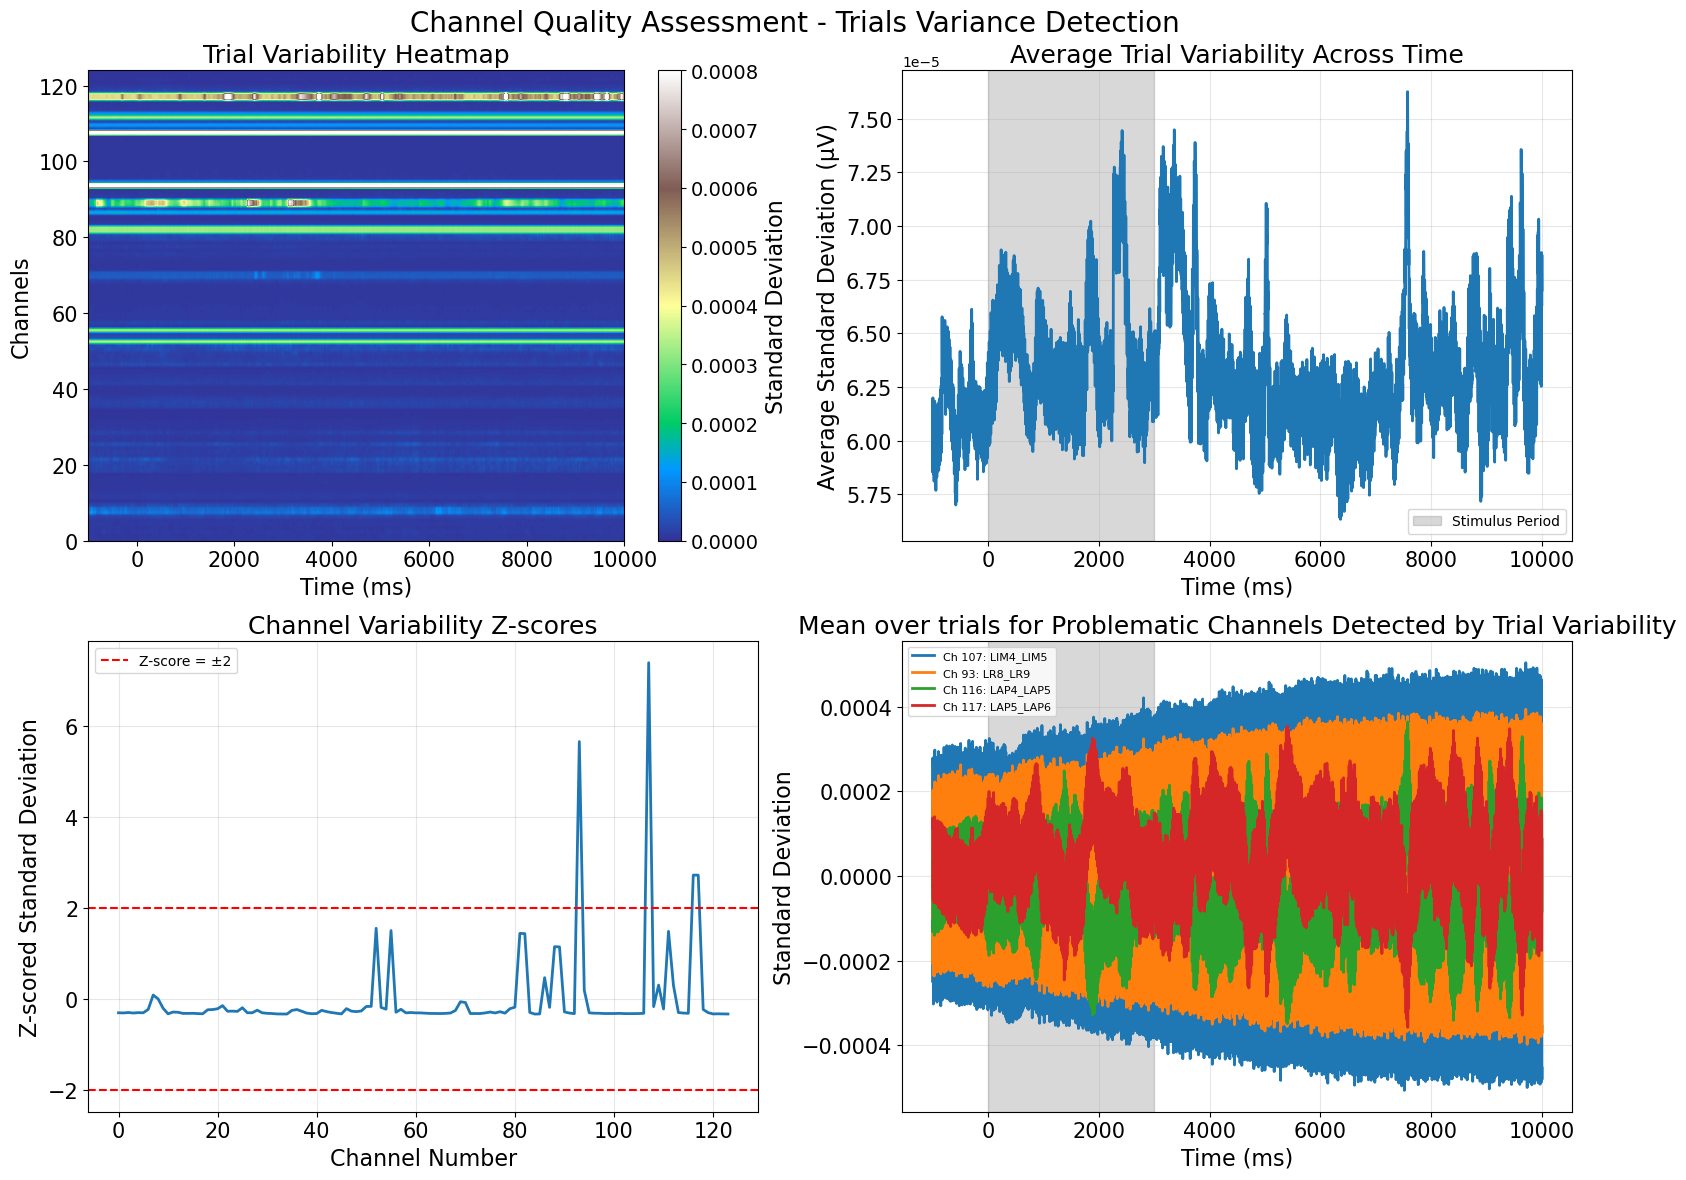

In [13]:

trial_variability = np.std(eeg_no_encoding[:,channel, :],axis=0)  # Shape: (channels, timepoints)
timepoint_variability = np.mean(trial_variability, axis=0)  # Average across channels
channel_variability = np.mean(trial_variability, axis=1)  # Average across timepoints

# Z-score channel variability to identify outliers
channel_variability_z = zscore(channel_variability)
problematic_channels = np.where(np.abs(channel_variability_z) > 2)[0]

print(f"Total channels analyzed: {len(channels)}")
print(f"Channels with high variability (|z-score| > 2): {len(problematic_channels)}")

if len(problematic_channels) > 0:
    print("\nPotential problematic channels:")
    for ch_idx in problematic_channels:
        if ch_idx < len(channels):
            print(f"  Channel {ch_idx}: {channels.iloc[ch_idx]} (z-score: {channel_variability_z[ch_idx]:.2f})")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Channel Quality Assessment - Trials Variance Detection', fontsize=20)
ax2.tick_params(axis='both', labelsize=15)



#ax1 = axes[0, 0]
#im = ax1.imshow(trial_variability, aspect='auto', cmap='gist_ncar', origin='lower',
                #extent=[time_axis[0], time_axis[-1], 0, trial_variability.shape[0]])
#ax1.set_xlabel('Time (ms)', fontsize = 16)
#ax1.set_ylabel('Channels', fontsize = 16)
#ax1.set_title('Trial Variability Heatmap', fontsize = 16)

#fig, ax = plt.subplots()
#ax.imshow(image_data)
#ax.tick_params(axis='both', labelsize=20)
#plt.show()


# Heatmap of trial variability

ax1 = axes[0, 0]
im = ax1.imshow(
    trial_variability,
    aspect='auto',
    cmap='terrain',
    origin='lower',
    extent=[time_axis[0], time_axis[-1], 0, trial_variability.shape[0]],
    vmin=0.0,
    vmax=0.0008
)
ax1.set_xlabel('Time (ms)', fontsize=16)
ax1.set_ylabel('Channels', fontsize=16)
ax1.set_title('Trial Variability Heatmap', fontsize=18)
ax1.tick_params(axis='both', labelsize=15)
#plt.colorbar(im, ax=ax1, label='Standard Deviation')
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Standard Deviation', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Average variability across time
ax2 = axes[0, 1]
ax2.plot(time_axis, timepoint_variability, linewidth=2)
ax2.set_xlabel('Time (ms)', fontsize = 16)
ax2.set_ylabel('Average Standard Deviation (µV)', fontsize = 16)
ax2.set_title('Average Trial Variability Across Time', fontsize = 18)
ax2.grid(True, alpha=0.3)
ax2.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey', label='Stimulus Period')
ax2.legend()
ax2.tick_params(axis='both', labelsize=15)


# Channel variability z-scores
ax3 = axes[1, 0]
ax3.plot(channel_variability_z, linewidth=2)
ax3.axhline(y=2, color='r', linestyle='--', label='Z-score = ±2')
ax3.axhline(y=-2, color='r', linestyle='--')
ax3.set_xlabel('Channel Number', fontsize = 16)
ax3.set_ylabel('Z-scored Standard Deviation', fontsize = 16)

ax3.set_title('Channel Variability Z-scores', fontsize = 18)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.tick_params(axis='both', labelsize=15)



# Problematic channels over time
sorted_problematicchannels = np.sort(problematic_channels)[::-1]

import numpy as np
values = np.array([107, 93, 116,117])
sort_keys = np.array([1, 2, 3, 4])
# Get indices that would sort sort_keys
sorted_indices = np.argsort(sort_keys) 
# [1, 3, 0, 2]
# Apply those indices to values
sorted_values = values[sorted_indices]

#ax4 = axes[1, 1]
#if len(problematic_channels) > 0:
    #for ch in sorted_problematicchannels[:4]:  # Plot up to 8 problematic channels
        #if ch < trial_variability.shape[0]:
            #ax4.plot(time_axis, np.mean(eeg_no_encoding[:, ch, :], axis=0), 
                 #   label=f'Ch {ch}: {channels[ch] if ch < len(channels) else "Unknown"}', 
               #     linewidth=2)
   # ax4.set_xlabel('Time (ms)', fontsize = 16)
    #ax4.set_ylabel('Voltage (µV)', fontsize = 16)
    #plt.xticks(fontsize = 12)
   # plt.yticks(fontsize = 12)
   # ax4.set_title('Mean over trials for Problematic Channels Detected by Trial Variability', fontsize = 16)
    #ax4.grid(True, alpha=0.3)
    #ax4.legend(fontsize=8)
   # ax4.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='lightgrey')
    
# Problematic channels over time (normalized so all are visible)
problematic_channels_sorted = problematic_channels[np.argsort(-channel_variability_z[problematic_channels])]
ax4 = axes[1, 1]
if len(problematic_channels) > 0:
    for ch in problematic_channels_sorted[:8]:  # Plot up to 8 problematic channels
        if ch < trial_variability.shape[0]:
            ax4.plot(time_axis, np.mean(eeg_no_encoding[:, ch, :], axis=0),
                    label=f'Ch {ch}: {channels[ch] if ch < len(channels) else "Unknown"}',
                    linewidth=2)
    ax4.set_xlabel('Time (ms)', fontsize=16)
    ax4.set_ylabel('Standard Deviation', fontsize=16)
    ax4.set_title('Mean over trials for Problematic Channels Detected by Trial Variability', fontsize=18)
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=8)
    ax4.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
 
    
    
plt.tight_layout()
plt.savefig(f"{write_fig_path}/2x2_Maps_ex.pdf", transparent=True, bbox_inches='tight', pad_inches=0.08, format='pdf')
plt.show()






In [14]:
problematic_channels

values = np.array([10, 20, 30, 40])
sort_keys = np.array([3, 1, 4, 2])
sort_keyssorted_indices = np.argsort(sort_keys)
valuessorted_values = values#[sorted_indices]

Total channels analyzed: 124
Channels with high timepoint variance (|z-score| > 2): 2

Potential Problematic Channels:
  Channel 93: LR8_LR9 (z-score: 5.52)
  Channel 107: LIM4_LIM5 (z-score: 9.27)


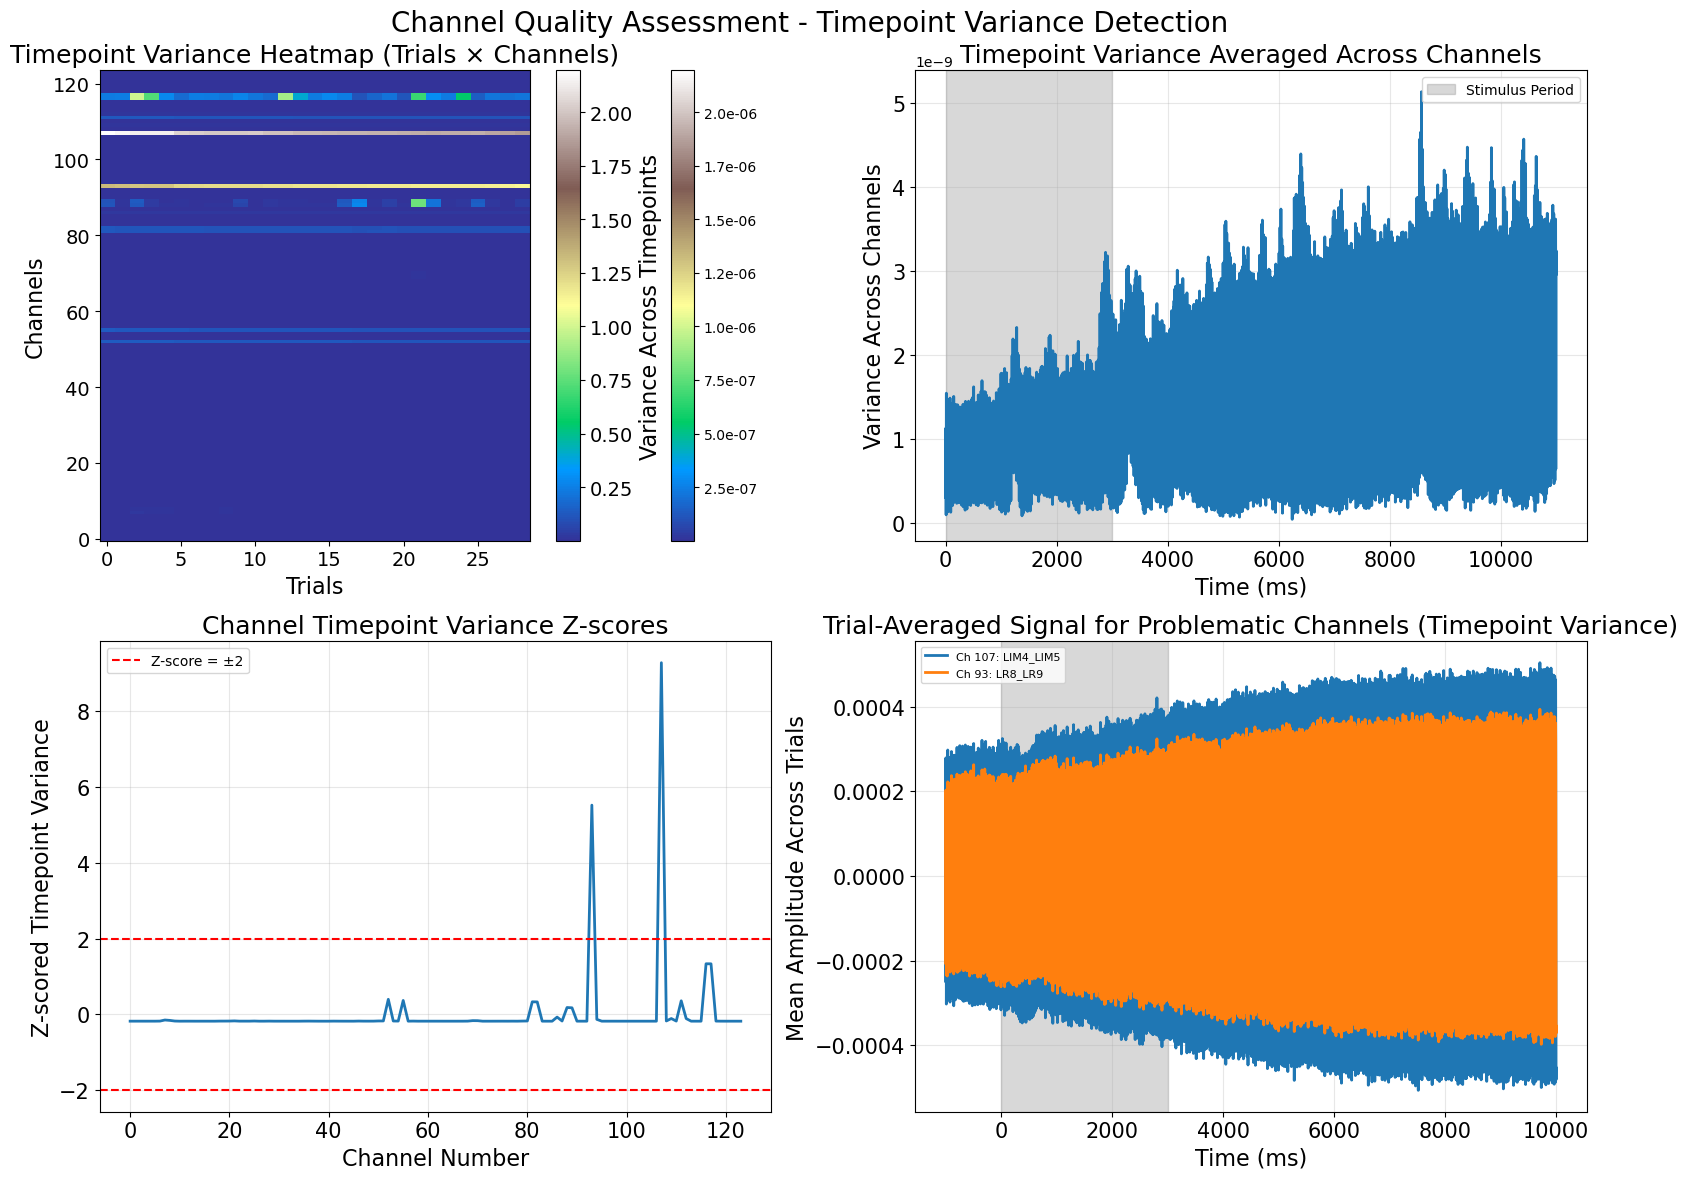

<Figure size 640x480 with 0 Axes>

In [15]:


timepoint_variance = np.var(eeg_no_encoding[:, channel, :], axis=2)  # Shape: (trials, channels) - variance across timepoints
trial_averaged_variance = np.mean(timepoint_variance, axis=0)  # Shape: (channels,) - average across trials
# For visualization: compute variance profiles
channel_timepoint_variance = np.var(np.mean(eeg_no_encoding[:, channel, :], axis=0), axis=1)  # Shape: (channels,) - variance across timepoints for trial-averaged data
timepoint_channel_variance = np.var(np.mean(eeg_no_encoding[:, channel, :], axis=0), axis=0)  # Shape: (timepoints,) - variance across channels for trial-averaged data
# Z-score channel variance to identify outliers
channel_variance_z = zscore(trial_averaged_variance)
problematic_channels = np.where(np.abs(channel_variance_z) > 2)[0]
problematic_channels_sorted = problematic_channels[np.argsort(-channel_variance_z[problematic_channels])]
print(f"Total channels analyzed: {len(channels)}")
print(f"Channels with high timepoint variance (|z-score| > 2): {len(problematic_channels)}")
if len(problematic_channels) > 0:
    print("\nPotential Problematic Channels:")
    for ch_idx in problematic_channels:
        if ch_idx < len(channels):
            print(f"  Channel {ch_idx}: {channels.iloc[ch_idx]} (z-score: {channel_variance_z[ch_idx]:.2f})")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Channel Quality Assessment - Timepoint Variance Detection', fontsize=20)
# Heatmap of timepoint variance across trials and channels
#ax1 = axes[0, 0]

#ax1 = axes[0, 0]
#im = ax1.imshow


#im = ax1.imshow(timepoint_variance.T, aspect='auto', cmap='terrain', origin='lower')
ax1 = axes[0, 0]

im = ax1.imshow(
    timepoint_variance.T,
    aspect='auto',
    cmap='terrain',
    origin='lower',
    #vmin=0.0,
    #vmax=np.max(timepoint_variance)
  
)
cbar = plt.colorbar(im, ax=ax1, format='%.1e')

##im = ax1.imshow(
 #   timepoint_variance.T / np.max(timepoint_variance) * 0.0008,
 #   aspect='auto',
  #  cmap='terrain',
   # origin='lower',
   # vmin=0.0,
  #  vmax=0.0008
#)
ax1.set_xlabel('Trials', fontsize=16)
ax1.set_ylabel('Channels', fontsize=16)
ax1.set_title('Timepoint Variance Heatmap (Trials × Channels)', fontsize=18)


ax1.tick_params(axis='both', labelsize=14)  # axis ticks

cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Variance Across Timepoints', fontsize=16)  # colorbar title
cbar.ax.tick_params(labelsize=14)  # colorbar tick labels

# REMOVE the scientific notation scale text (the "1e6")
cbar.ax.yaxis.get_offset_text().set_visible(False)

#plt.colorbar(im, ax=ax1, label='Variance Across Timepoints')
#cbar.set_label('Variance Across Timepoints', fontsize=16)

#cbar.ax.tick_params(labelsize=14)


# Average variability across channels over time
ax2 = axes[0, 1]
ax2.plot(timepoint_channel_variance, linewidth=2)
ax2.set_xlabel('Time (ms)', fontsize=16)
ax2.set_ylabel('Variance Across Channels', fontsize=16)
ax2.set_title('Timepoint Variance Averaged Across Channels', fontsize=18)
ax2.grid(True, alpha=0.3)
ax2.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey', label='Stimulus Period')
ax2.tick_params(axis='both', labelsize=15)
ax2.legend()
# Channel variance z-scores
ax3 = axes[1, 0]
ax3.plot(channel_variance_z, linewidth=2)
ax3.axhline(y=2, color='r', linestyle='--', label='Z-score = ±2')
ax3.axhline(y=-2, color='r', linestyle='--')
ax3.set_xlabel('Channel Number', fontsize=16)
ax3.set_ylabel('Z-scored Timepoint Variance', fontsize=16)
ax3.set_title('Channel Timepoint Variance Z-scores', fontsize=18)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', labelsize=15)
ax3.legend()
# Problematic channels - timepoint variance profiles
ax4 = axes[1, 1]
if len(problematic_channels) > 0:
    for ch in problematic_channels_sorted[:8]:  # Plot up to 8 problematic channels
        if ch < len(channels):
            channel_signal_over_time = np.mean(eeg_no_encoding[:, ch, :], axis=0)  # Mean amplitude across trials at each timepoint
            ax4.plot(time_axis, channel_signal_over_time,
                    label=f'Ch {ch}: {channels.iloc[ch]}',
                    linewidth=2)
    ax4.set_xlabel('Time (ms)', fontsize=16)
    ax4.set_ylabel('Mean Amplitude Across Trials', fontsize=16)
    ax4.set_title('Trial-Averaged Signal for Problematic Channels (Timepoint Variance)', fontsize=18)
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=8)
    ax4.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='grey')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    plt.tight_layout()
    fig.savefig(f"4_graphs_2nd_map.pdf", transparent=True, bbox_inches='tight', pad_inches=0.08)
    plt.show()
    
else:
    ax4.text(0.5, 0.5, 'No problematic channels detected',
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Trial-Averaged Signal for Problematic Channels (Timepoint Variance)')
plt.tight_layout()
plt.show()

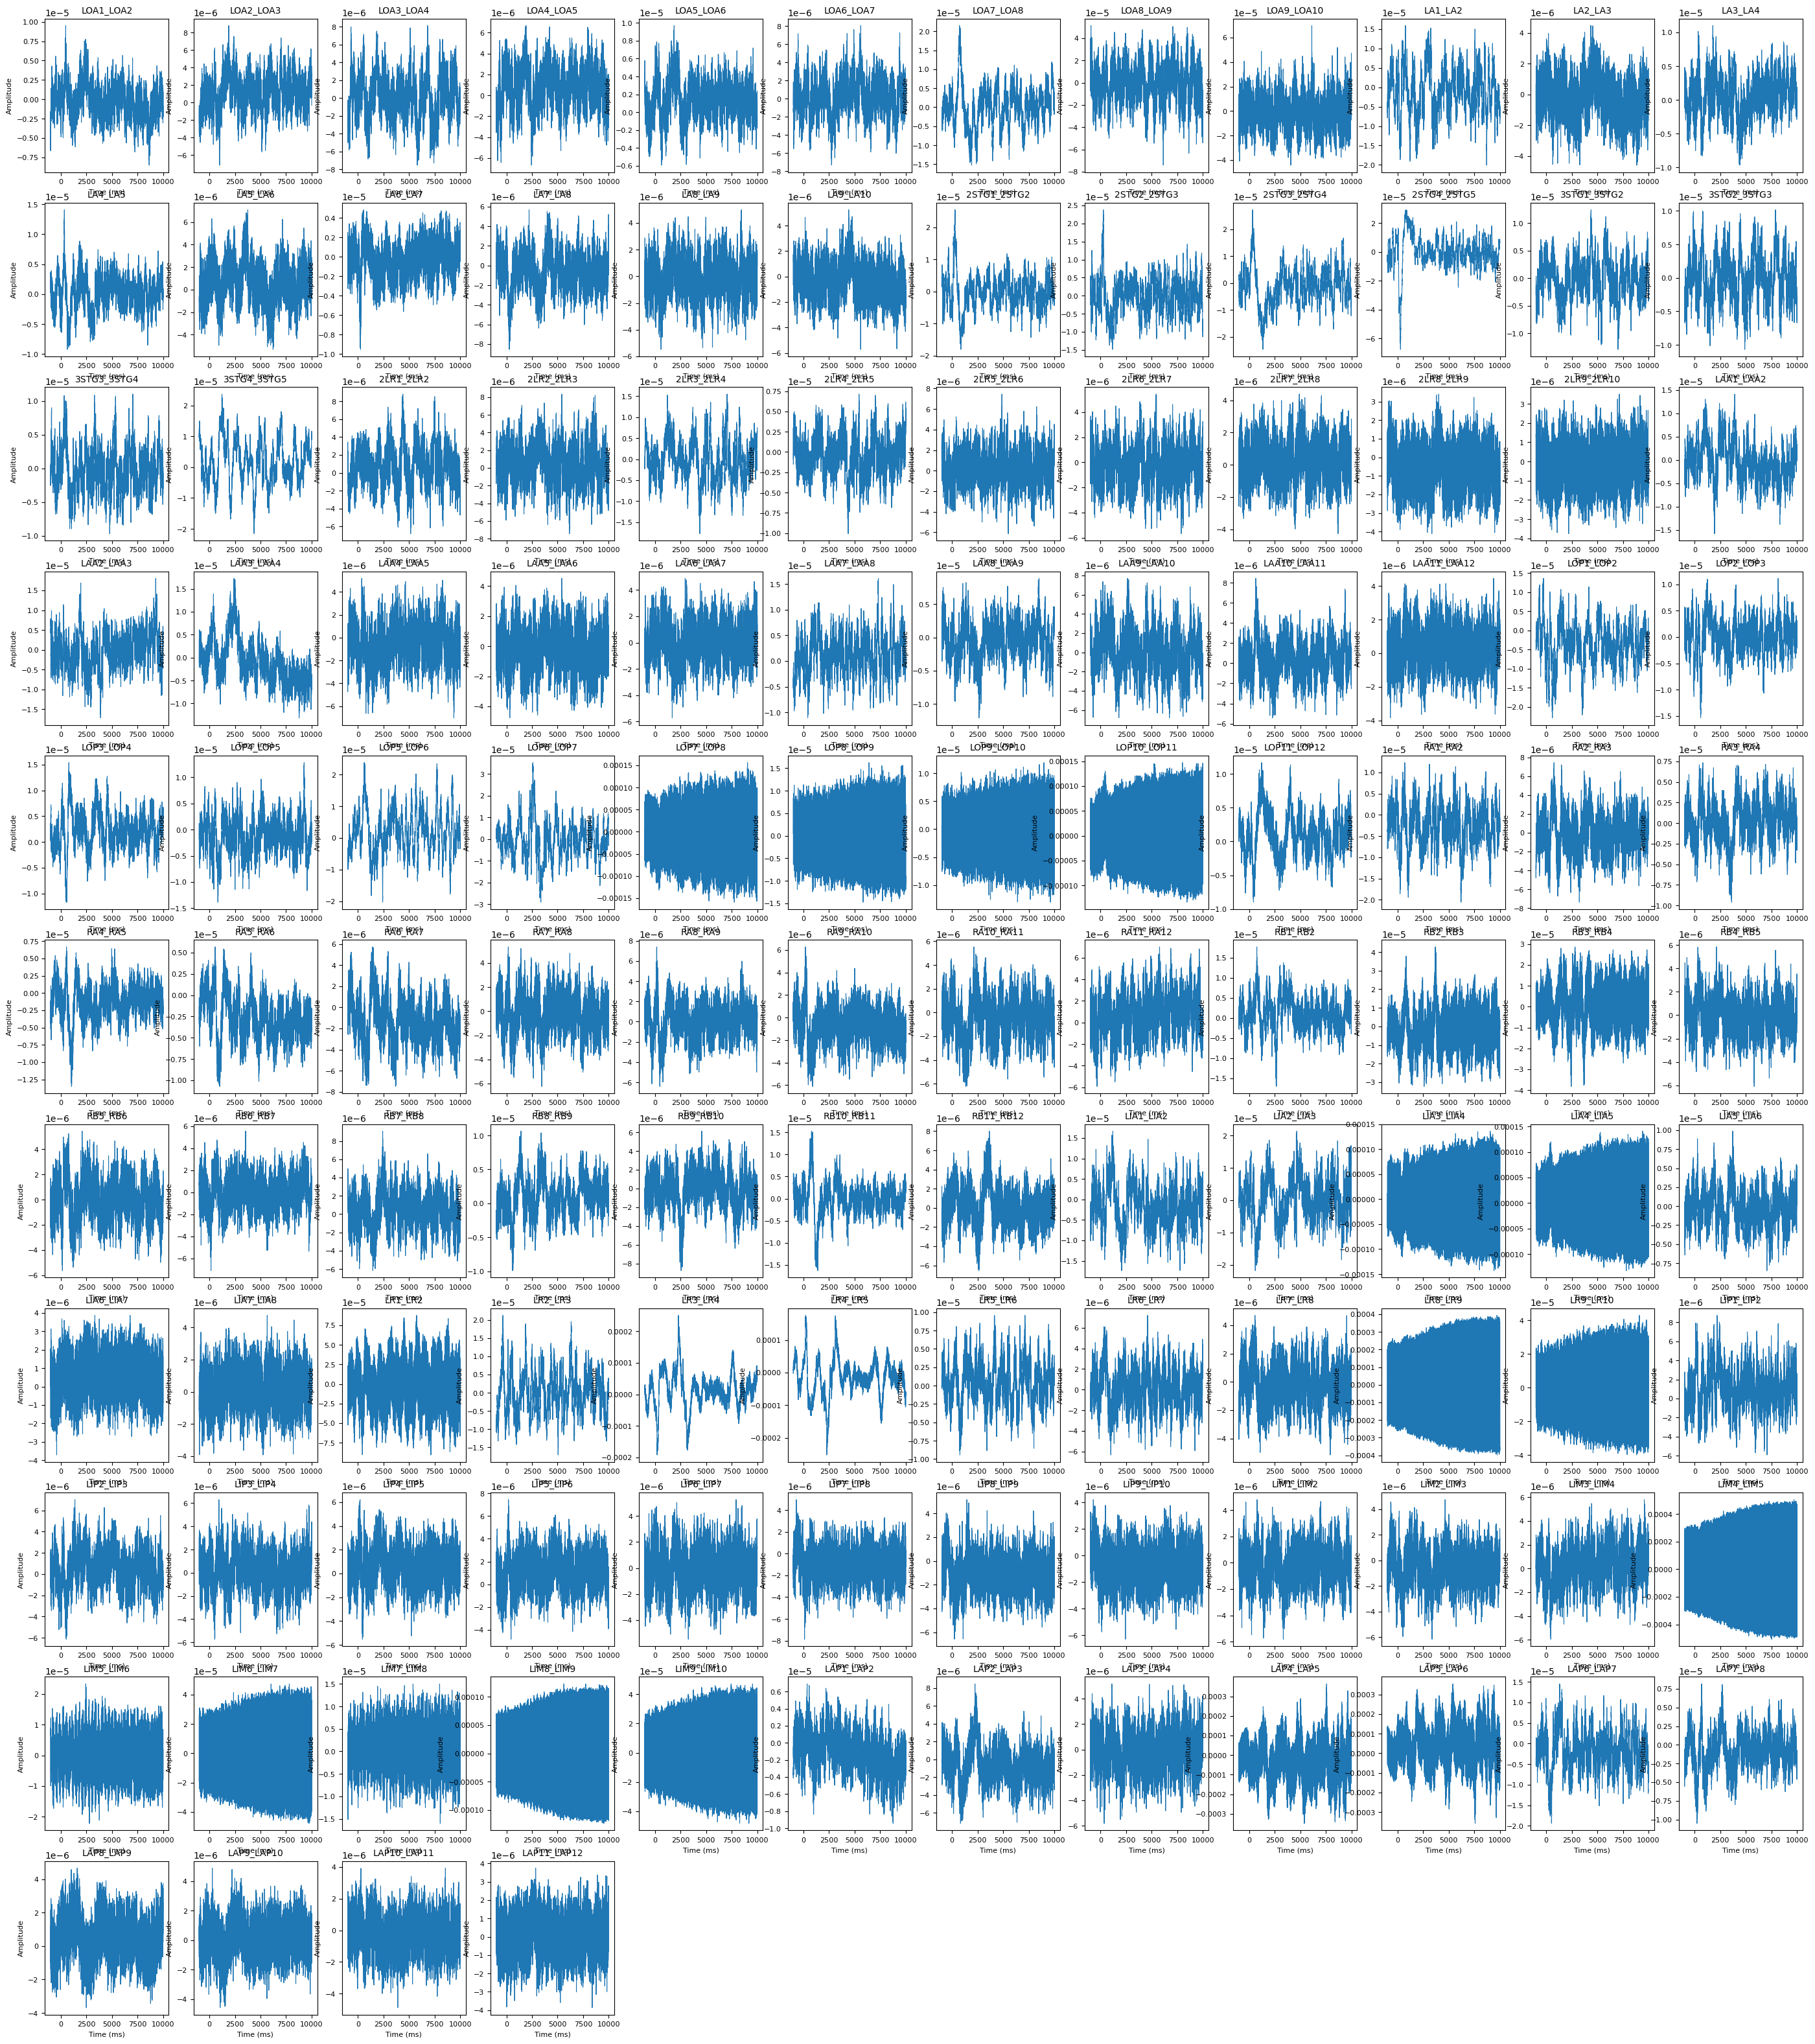

In [16]:
import matplotlib.pyplot as plt
import numpy as np

mean_data = np.mean(eeg_no_encoding, axis=0)  # Shape: (53, 22000)

# Calculate grid dimensions (approximate square layout)
n_channels = mean_data.shape[0]
n_cols = int(np.ceil(np.sqrt(n_channels)))
n_rows = int(np.ceil(n_channels / n_cols))

# Create subplots WITHOUT shared y-axis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(35, 40))  # Removed sharey=True
axes = axes.flatten()  # Make it easier to iterate

# Plot each channel in its own subplot
for channel in range(n_channels):
    axes[channel].plot(time_axis, mean_data[channel, :], linewidth=0.8)
    axes[channel].set_title(channels.iloc[channel], fontsize=10)
    axes[channel].set_xlabel('Time (ms)', fontsize=8)
    axes[channel].set_ylabel('Amplitude', fontsize=8)
    axes[channel].tick_params(labelsize=8)

# Hide any unused subplots
for i in range(n_channels, len(axes)):
    axes[i].set_visible(False)

plt.show()

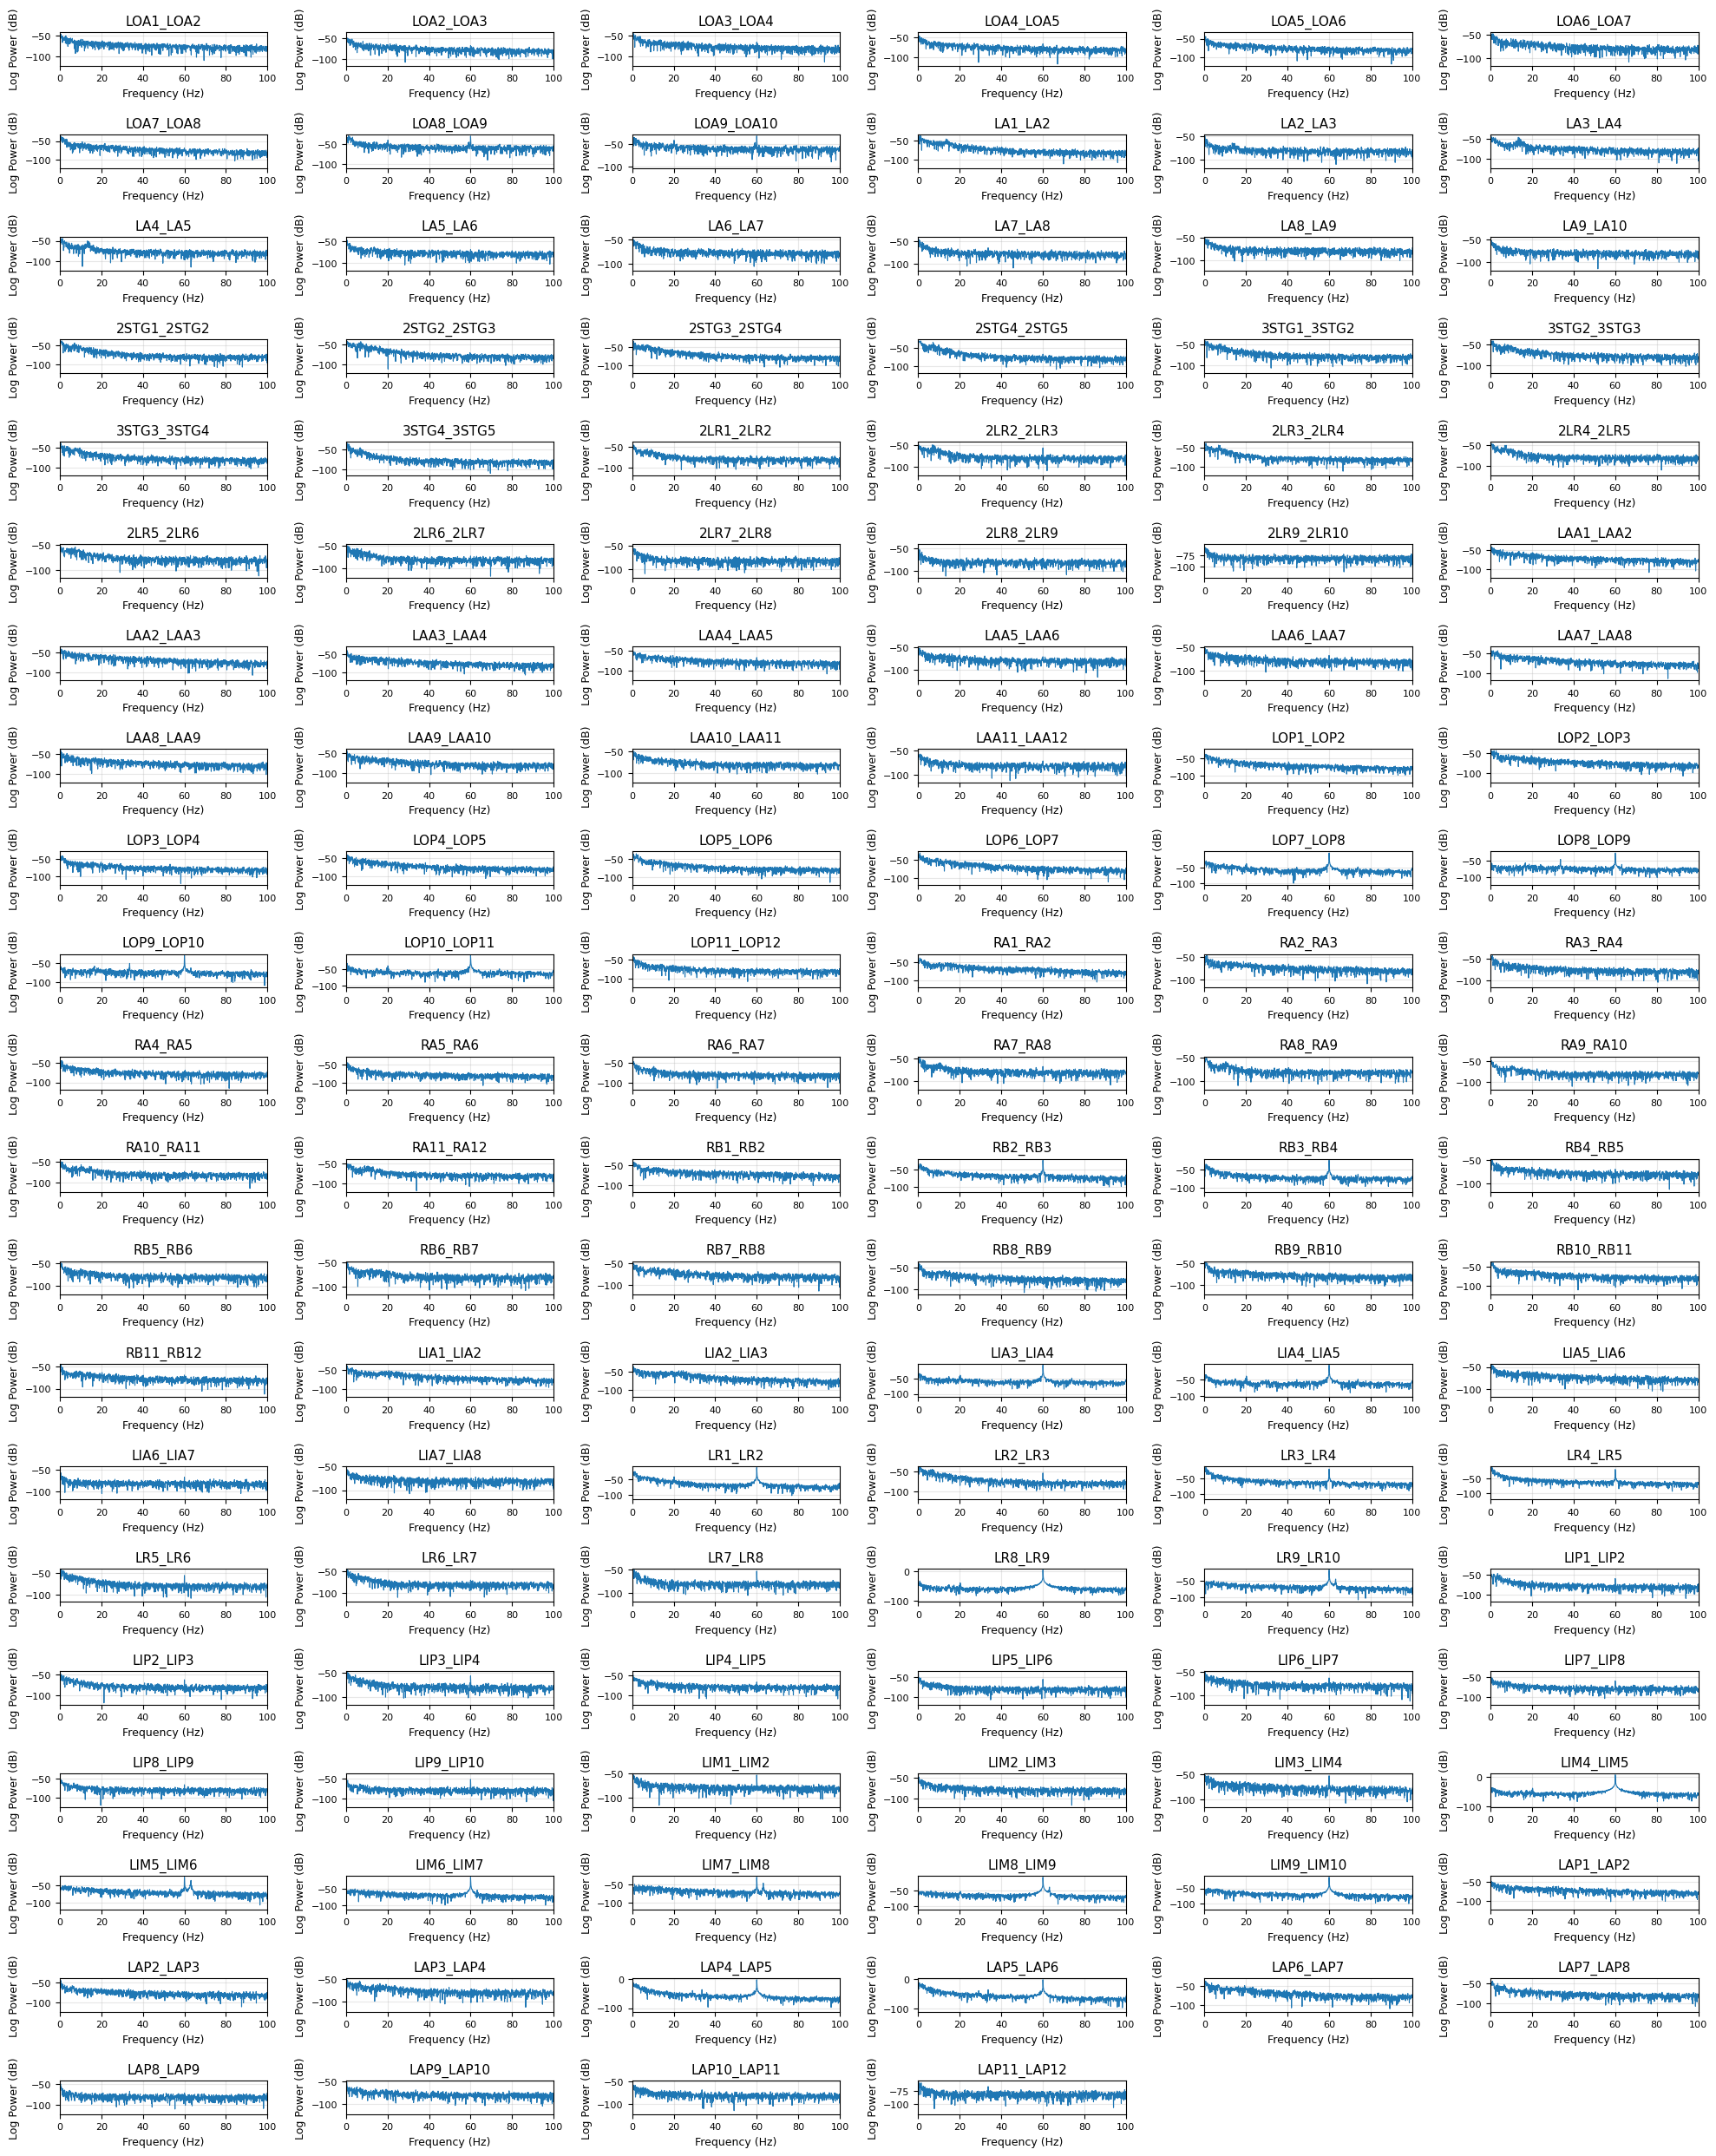

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

mean_data = np.mean(eeg_no_encoding, axis=0)  # Shape: (53, 22000)

# FFT parameters
sampling_rate = 1000  # Hz - adjust this to your actual sampling rate
n_samples = mean_data.shape[1]

# Calculate frequency axis
freqs = fftfreq(n_samples, 1/sampling_rate)[:n_samples//2]  # Only positive frequencies

# Use fewer columns for larger subplots
n_channels = mean_data.shape[0]
n_cols = min(6, int(np.ceil(np.sqrt(n_channels))))
n_rows = int(np.ceil(n_channels / n_cols))

# Create larger figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))
axes = axes.flatten()

# Plot FFT log power for each channel
for channel in range(n_channels):
    # Compute FFT
    fft_data = fft(mean_data[channel, :])
    
    # Calculate power spectrum (magnitude squared)
    power_spectrum = np.abs(fft_data[:n_samples//2])**2
    
    # Convert to log power (dB)
    log_power = 10 * np.log10(power_spectrum + 1e-12)  # Add small value to avoid log(0)
    
    # Plot
    axes[channel].plot(freqs, log_power, linewidth=0.8)
    axes[channel].set_title(channels.iloc[channel], fontsize=11)
    axes[channel].set_xlabel('Frequency (Hz)', fontsize=9)
    axes[channel].set_ylabel('Log Power (dB)', fontsize=9)
    axes[channel].tick_params(labelsize=8)
    axes[channel].grid(True, alpha=0.3)
    
    # Optional: limit frequency range to typical EEG bands (0-100 Hz)
    axes[channel].set_xlim(0, 100)

# Hide unused subplots
for i in range(n_channels, len(axes)):
    axes[i].set_visible(False)

# Optimize layout
plt.tight_layout(pad=1.5)
plt.show()

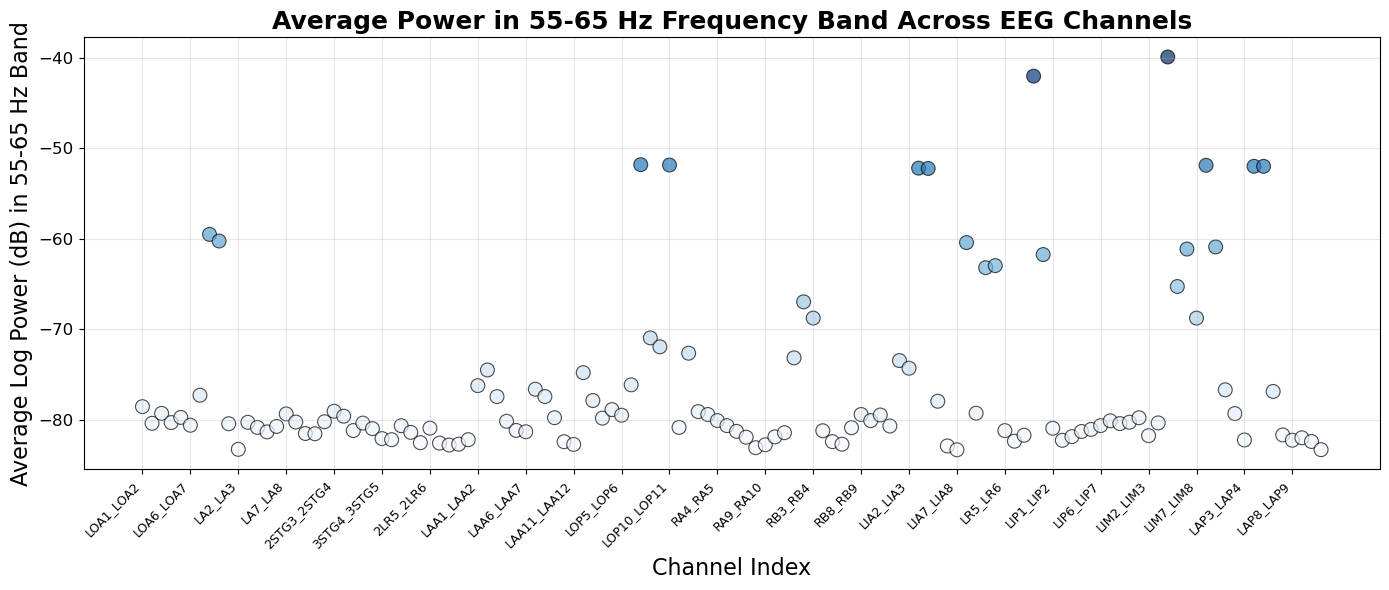

55-65 Hz Band Power Summary:
Mean: -76.2483 dB
Std Dev: 9.3936 dB
Min: -83.3476 dB (Channel 85)
Max: -39.8960 dB (Channel 107)


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

# Compute mean and FFT parameters
mean_data = np.mean(eeg_no_encoding, axis=0)  # Shape: (53, 22000)
sampling_rate = 1000  # Hz
n_samples = mean_data.shape[1]

# Calculate frequency axis
freqs = fftfreq(n_samples, 1/sampling_rate)[:n_samples//2]

# Define frequency band of interest
freq_min, freq_max = 55, 65
freq_mask = (freqs >= freq_min) & (freqs <= freq_max)

n_channels = mean_data.shape[0]

# Extract average power in 55-65 Hz band for each channel
band_powers = []

for channel in range(n_channels):
    # Compute FFT
    fft_data = fft(mean_data[channel, :])
    
    # Calculate power spectrum
    power_spectrum = np.abs(fft_data[:n_samples//2])**2
    
    # Convert to log power (dB)
    log_power = 10 * np.log10(power_spectrum + 1e-12)
    
    # Average power in 55-65 Hz band
    band_power = np.mean(log_power[freq_mask])
    band_powers.append(band_power)

band_powers = np.array(band_powers)

# Create scatter plot
fig, ax = plt.subplots(figsize=(14, 6))

channel_indices = np.arange(n_channels)
#colors = plt.cm.viridis(np.linspace(0, 1, n_channels))
# Normalize band powers to [0, 1] for colormap
norm = plt.Normalize(vmin=np.min(band_powers), vmax=np.max(band_powers))
colors = plt.cm.Blues(norm(band_powers))


ax.scatter(channel_indices, band_powers, s=100, alpha=0.7, c=colors, edgecolors='black', linewidth=0.8)

ax.set_xlabel('Channel Index', fontsize=16)
ax.set_ylabel('Average Log Power (dB) in 55-65 Hz Band', fontsize=16)
ax.set_title('Average Power in 55-65 Hz Frequency Band Across EEG Channels', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.3)
#x.tick_params(labelsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


# Optional: add channel names if available
if 'channels' in locals():
    ax.set_xticks(channel_indices[::5])  # Show every 5th label to avoid crowding
    ax.set_xticklabels([channels.iloc[i] for i in channel_indices[::5]], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
#fig.savefig(f"averagepower_dot_graph.pdf", transparent=True, bbox_inches='tight', pad_inches=0.08)
plt.show()

# Print summary statistics
print(f"55-65 Hz Band Power Summary:")
print(f"Mean: {np.mean(band_powers):.4f} dB")
print(f"Std Dev: {np.std(band_powers):.4f} dB")
print(f"Min: {np.min(band_powers):.4f} dB (Channel {np.argmin(band_powers)})")
print(f"Max: {np.max(band_powers):.4f} dB (Channel {np.argmax(band_powers)})")

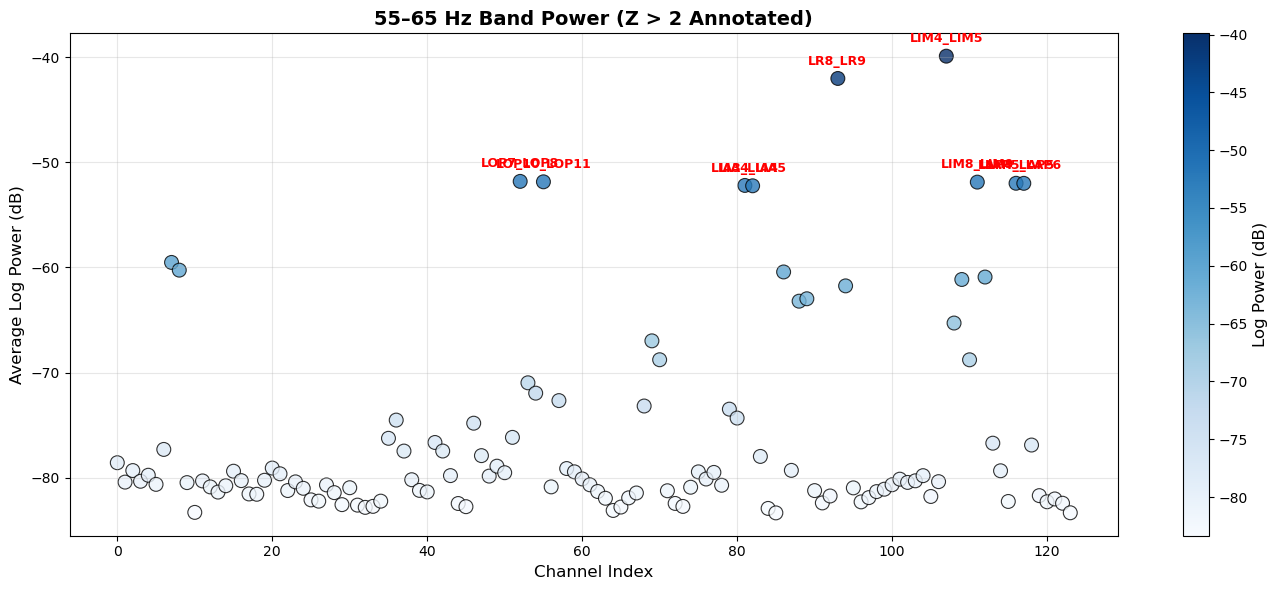

In [19]:




# ---- Z-SCORES ----
z_scores = (band_powers - np.mean(band_powers)) / np.std(band_powers)

# ---- FIGURE ----
fig, ax = plt.subplots(figsize=(14, 6))

channel_indices = np.arange(n_channels)

# ---- COLORS ----
norm = plt.Normalize(vmin=np.min(band_powers), vmax=np.max(band_powers))
colors = plt.cm.Blues(norm(band_powers))

# ---- SCATTER ----
ax.scatter(
    channel_indices,
    band_powers,
    s=100,
    alpha=0.8,
    c=colors,
    edgecolors='black',
    linewidth=0.8
)

# ---- ANNOTATIONS (Z > 2) ----
for i in range(n_channels):
    if z_scores[i] > 2:
        ax.annotate(
            channels.iloc[i] if hasattr(channels, "iloc") else channels[i],
            (i, band_powers[i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            fontsize=9,
            color='red',
            fontweight='bold'
        )

# ---- AXES ----
ax.set_xlabel('Channel Index', fontsize=12)
ax.set_ylabel('Average Log Power (dB)', fontsize=12)
ax.set_title('55–65 Hz Band Power (Z > 2 Annotated)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# ---- COLORBAR ----
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Log Power (dB)', fontsize=12)

plt.tight_layout()
plt.show()







## Calculate z-scores
#z_scores = (band_powers - np.mean(band_powers)) / np.std(band_powers)

# Print channels with z-score > 2
#print("\n" + "="*80)
#print("Channels with Z-score > 2 (2 standard deviations above mean):")
#print("="*80)
#high_power_channels = [(channels[i], band_powers[i], z_scores[i]) 
 #                       for i in range(n_channels) if z_scores[i] > 2]

#if high_power_channels:
 #   for ch_name, power, z_score in sorted(high_power_channels, key=lambda x: x[2], reverse=True):
  #      print(f"  {ch_name:15s} | Power: {power:8.4f} dB | Z-score: {z_score:6.4f}")
#else:
 #   print("  No channels found with Z-score > 2")

#print("\n" + "="*80)
#print("All Channel Powers (sorted by power):")
#print("="*80)
#sorted_indices = np.argsort(band_powers)[::-1]
#for idx in sorted_indices:
 #   ch_name = channels[idx]
  #  power = band_powers[idx]
   # z_score = z_scores[idx]
    #marker = " ← Z > 2" if z_score > 2 else ""
    #print(f"  {ch_name:15s} | Power: {power:8.4f} dB | Z-score: {z_score:6.4f}{marker}")
    
#ax.scatter(channel_indices, band_powers, s=100, alpha=0.7, c=colors, edgecolors='black', linewidth=0.8)
# ... axis labels, title, ticks, grid, etc ...

# Annotations go here
#for i in range(n_channels):
 #   if z_scores[i] > 2:
  #      ax.annotate(
   #         channels[i],
    #        (i, band_powers[i]),
     #       textcoords="offset points",
      #      xytext=(0, 10),
       #     ha='center', fontsize=9,
        #    color='red', fontweight='bold'
        #)

# Optional: add colorbar
#sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Log Power (dB)', fontsize=12)

# Show the plot
#plt.show()
    
    


In [20]:
channels

0        LOA1_LOA2
1        LOA2_LOA3
2        LOA3_LOA4
3        LOA4_LOA5
4        LOA5_LOA6
          ...     
119      LAP7_LAP8
120      LAP8_LAP9
121     LAP9_LAP10
122    LAP10_LAP11
123    LAP11_LAP12
Name: name, Length: 124, dtype: object

In [21]:
channel_names

NameError: name 'channel_names' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

# Compute mean and FFT parameters
mean_data = np.mean(eeg_no_encoding, axis=0)  # Shape: (53, 22000)
sampling_rate = 1000  # Hz
n_samples = mean_data.shape[1]

# Calculate frequency axis
freqs = fftfreq(n_samples, 1/sampling_rate)[:n_samples//2]

# Define frequency band of interest
freq_min, freq_max = 8, 15
freq_mask = (freqs >= freq_min) & (freqs <= freq_max)

n_channels = mean_data.shape[0]

# Extract average power in 55-65 Hz band for each channel
band_powers = []

for channel in range(n_channels):
    # Compute FFT
    fft_data = fft(mean_data[channel, :])
    
    # Calculate power spectrum
    power_spectrum = np.abs(fft_data[:n_samples//2])**2
    
    # Convert to log power (dB)
    log_power = 10 * np.log10(power_spectrum + 1e-12)
    
    # Average power in 55-65 Hz band
    band_power = np.mean(log_power[freq_mask])
    band_powers.append(band_power)

band_powers = np.array(band_powers)

# Create scatter plot
fig, ax = plt.subplots(figsize=(14, 6))

channel_indices = np.arange(n_channels)
colors = plt.cm.viridis(np.linspace(0, 1, n_channels))

ax.scatter(channel_indices, band_powers, s=100, alpha=0.7, c=colors, edgecolors='black', linewidth=0.8)

ax.set_xlabel('Channel Index', fontsize=12)
ax.set_ylabel('Average Log Power (dB) in 55-65 Hz Band', fontsize=12)
ax.set_title('Average Power in 55-65 Hz Frequency Band Across EEG Channels', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=10)

# Optional: add channel names if available
if 'channels' in locals():
    ax.set_xticks(channel_indices[::5])  # Show every 5th label to avoid crowding
    ax.set_xticklabels([channels.iloc[i] for i in channel_indices[::5]], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"55-65 Hz Band Power Summary:")
print(f"Mean: {np.mean(band_powers):.4f} dB")
print(f"Std Dev: {np.std(band_powers):.4f} dB")
print(f"Min: {np.min(band_powers):.4f} dB (Channel {np.argmin(band_powers)})")
print(f"Max: {np.max(band_powers):.4f} dB (Channel {np.argmax(band_powers)})")

In [ ]:
# Calculate z-scores
z_scores = (band_powers - np.mean(band_powers)) / np.std(band_powers)

# Print channels with z-score > 2
print("\n" + "="*80)
print("Channels with Z-score <2 (2 standard deviations above mean):")
print("="*80)
low_power_channels = [(channel_names[i], band_powers[i], z_scores[i]) 
                       for i in range(n_channels) if z_scores[i] < -2]

if low_power_channels:
    for ch_name, power, z_score in sorted(low_power_channels, key=lambda x: x[2], reverse=True):
        print(f"  {ch_name:15s} | Power: {power:8.4f} dB | Z-score: {z_score:6.4f}")
else:
    print("  No channels found with Z-score > 2")

print("\n" + "="*80)
print("All Channel Powers (sorted by power):")
print("="*80)
sorted_indices = np.argsort(band_powers)[::-1]
for idx in sorted_indices:
    ch_name = channel_names[idx]
    power = band_powers[idx]
    z_score = z_scores[idx]
    marker = " ← Z <-2" if z_score < -2 else ""
    print(f"  {ch_name:15s} | Power: {power:8.4f} dB | Z-score: {z_score:6.4f}{marker}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

mean_data = np.mean(eeg_no_encoding, axis=0)  # Shape: (53, 22000)

# FFT parameters
sampling_rate = 1000  # Hz - adjust this to your actual sampling rate
n_samples = mean_data.shape[1]

# Calculate frequency axis
freqs = fftfreq(n_samples, 1/sampling_rate)[:n_samples//2]  # Only positive frequencies

# Use fewer columns for larger subplots
n_channels = mean_data.shape[0]
n_cols = min(6, int(np.ceil(np.sqrt(n_channels))))
n_rows = int(np.ceil(n_channels / n_cols))

# Create larger figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))
axes = axes.flatten()

# Plot FFT power for each channel
for channel in range(n_channels):
    # Compute FFT
    fft_data = fft(mean_data[channel, :])
    
    # Calculate power spectrum (magnitude squared)
    power_spectrum = np.abs(fft_data[:n_samples//2])**2
    
    # Plot without log transformation
    axes[channel].plot(freqs, power_spectrum, linewidth=0.8)
    axes[channel].set_title(channels.iloc[channel], fontsize=11)
    axes[channel].set_xlabel('Frequency (Hz)', fontsize=9)
    axes[channel].set_ylabel('Power', fontsize=9)
    axes[channel].tick_params(labelsize=8)
    axes[channel].grid(True, alpha=0.3)
    
    # Optional: limit frequency range to typical EEG bands (0-100 Hz)
    axes[channel].set_xlim(0, 100)

# Hide unused subplots
for i in range(n_channels, len(axes)):
    axes[i].set_visible(False)

# Optimize layout
plt.tight_layout(pad=1.5)
plt.savefig('line_noise.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pwd

In [ ]:
fig, ax10 = plt.subplots()
ax10.plot(time_axis, avg_eeg_stimuli_3.T, linewidth=0.5)
ax10.axvline(x=0, color='k', linestyle='--')
ax10.set_xlim(950, 1050)  # Updated to show 950-1050ms range
ax10.set_xlabel('Time (ms)')
ax10.set_ylabel('Voltage')
ax10.axvline(x=1000, color='r', linestyle='--')
ax10.set_title('3 Hz Stimulated Pairs - Individual Trials (950-1050ms)')
plt.show()

fig, ax10 = plt.subplots()
ax10.plot(time_axis, avg_eeg_stimuli_8.T, linewidth=0.5)
ax10.axvline(x=1000, color='r', linestyle='--')  # Vertical line at 1000ms
ax10.set_xlim(950, 1050)  # Updated to show 950-1050ms range
ax10.set_xlabel('Time (ms)')
ax10.set_ylabel('Voltage')
ax10.set_title('8 Hz Stimulated Pairs - Individual Trials (950-1050ms)')
plt.show()

In [ ]:
# 3 Hz Stimulated Pairs - Individual Trials in Subplots
num_trials_3hz = avg_eeg_stimuli_3.shape[0]
fig, axes = plt.subplots(num_trials_3hz, 1, figsize=(10, 2*num_trials_3hz), sharex=True)

# Handle case where there's only one trial
if num_trials_3hz == 1:
    axes = [axes]

for i in range(num_trials_3hz):
    axes[i].plot(time_axis, avg_eeg_stimuli_3[i, :], linewidth=0.5)
    axes[i].axvline(x=0, color='k', linestyle='--')
    axes[i].axvline(x=1000, color='r', linestyle='--')
    axes[i].set_xlim(950, 2050)
    axes[i].set_ylabel('Voltage')
    axes[i].set_title(f'3 Hz - Trial {i+1}')

axes[-1].set_xlabel('Time (ms)')
plt.suptitle('3 Hz Stimulated Pairs - Individual Trials (950-1050ms)', fontsize=14)
plt.tight_layout()
plt.savefig('single_3.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
num_trials_8hz = avg_eeg_stimuli_8.shape[0]
fig, axes = plt.subplots(num_trials_8hz, 1, figsize=(10, 2*num_trials_8hz), sharex=True)

# Handle case where there's only one trial
if num_trials_3hz == 1:
    axes = [axes]

for i in range(num_trials_8hz):
    axes[i].plot(time_axis, avg_eeg_stimuli_8[i, :], linewidth=0.5)
    axes[i].axvline(x=0, color='k', linestyle='--')
    axes[i].axvline(x=1000, color='r', linestyle='--')
    axes[i].set_xlim(950, 2050)
    axes[i].set_ylabel('Voltage')
    axes[i].set_title(f'8 Hz - Trial {i+1}')

axes[-1].set_xlabel('Time (ms)')
plt.suptitle('3 Hz Stimulated Pairs - Individual Trials (950-1050ms)', fontsize=14)
plt.tight_layout()
plt.savefig('single_8.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
